In [1]:
import sys

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.subplots as subplots
from plotly.subplots import make_subplots

from scipy.stats import linregress, spearmanr, mannwhitneyu, kruskal
import statsmodels.formula.api as smf

from mystats import MyStatsFunctions
from myplots import MyPlots

import warnings
warnings.filterwarnings('ignore')

msf = MyStatsFunctions()
mp = MyPlots()

# Input Data

In [2]:
full_rating_data = pd.read_excel('Data/full_rating_data_s2.xlsx')
full_slope_data = pd.read_excel('Data/full_slope_data_s2.xlsx')
full_slope_diff_data = pd.read_excel('Data/full_slope_diff_data_s2.xlsx')

In [3]:
all_subjects_s1 = list(full_slope_data[full_slope_data['study'] == 'Study 1']['subject'])
all_subjects_s2 = list(full_slope_data[full_slope_data['study'] == 'Study 2']['subject'])

cushion_subjects_s1 = list(full_slope_data[(full_slope_data['study'] == 'Study 1') & (full_slope_data['method'] == 'cushion')]['subject'])
cushion_subjects_s2 = list(full_slope_data[(full_slope_data['study'] == 'Study 2') & (full_slope_data['method'] == 'cushion')]['subject'])

stretch_subjects_s1 = list(full_slope_data[(full_slope_data['study'] == 'Study 1') & (full_slope_data['method'] == 'stretch')]['subject'])
stretch_subjects_s2 = list(full_slope_data[(full_slope_data['study'] == 'Study 1') & (full_slope_data['method'] == 'stretch')]['subject'])

print(f'{len(all_subjects_s1)} {len(all_subjects_s2)} {len(cushion_subjects_s1)} {len(cushion_subjects_s1)} {len(stretch_subjects_s1)} {len(stretch_subjects_s1)}')

times = [i for i in range(0, 121, 20)]
times.extend([125])
times.extend([i for i in range(145, 248, 20)])
times.extend([250])
times.extend([i for i in range(270, 375, 20)])
times = [x / 60 for x in times]

all_rating_columns = ['Upper Back', 'Lower Back', 'pelvis_rating', 'butt_rating', 'upper_thigh_rating', 'lower_thigh_rating']

colors1 = ['#6A5ACD', '#FF1493']
colors = ['steelblue', 'darkorange']

44 44 22 22 22 22


## Participant Selection

3.0 9.0
40.0 105.0
150.0 180.0
40.0 66.0
16.0 34.0


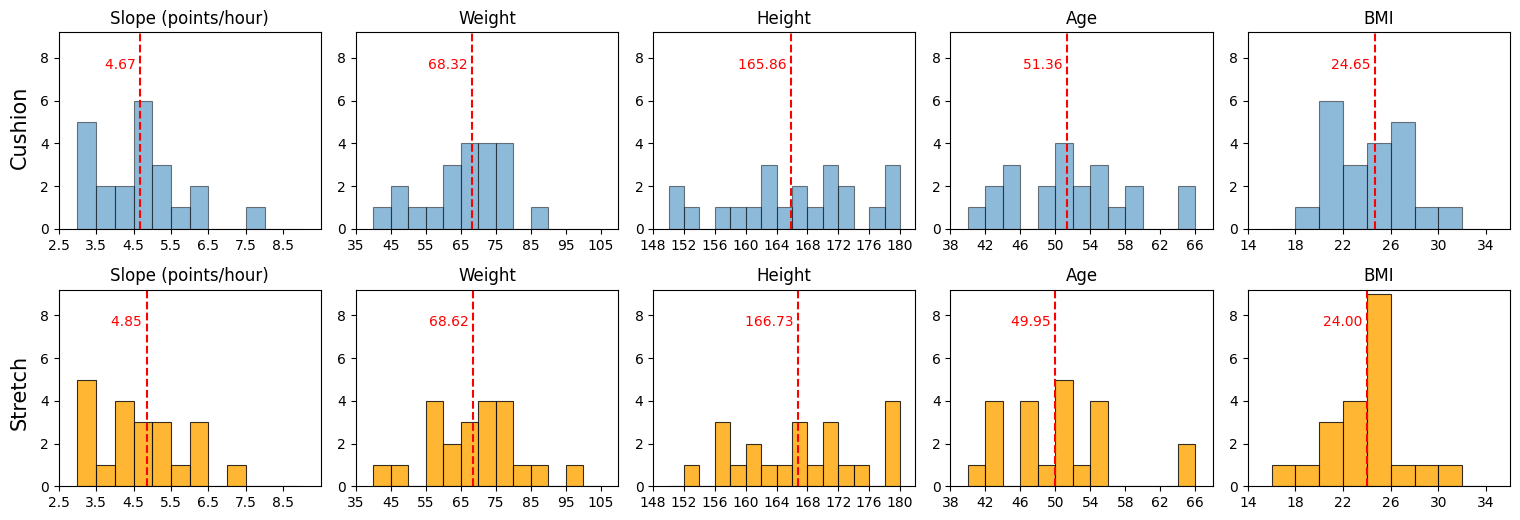

In [4]:
anthro = pd.read_excel('Data/S1_slope_anthro.xlsx')
anthro['Slope (points/hour)'] = anthro['slope_hour']
anthro_cushion = anthro[anthro['method'] == 'cushion']
anthro_stretch = anthro[anthro['method'] == 'stretch']

fig, ax = plt.subplots(2, 5, figsize=(15, 5.3))

bin_size = [0.5, 5, 2, 2, 2]

for i, col in enumerate(['Slope (points/hour)', 'Weight', 'Height', 'Age', 'BMI']):
    bs = bin_size[i]
    
    a = np.floor(min(min(anthro_cushion[col]), min(anthro_stretch[col])) / bs) * bs
    b = np.floor(max(max(anthro_cushion[col]), max(anthro_stretch[col])) / bs) * bs
        
    ax[0, i].hist(anthro_cushion[col], color='#1f77b4', bins=np.arange(a, b+bs, bs), alpha=0.5, edgecolor='black', linewidth=0.8)
    ax[1, i].hist(anthro_stretch[col], color='orange', bins=np.arange(a, b+bs, bs), alpha=0.8, edgecolor='black', linewidth=0.8)

    mean_cushion = np.mean(anthro_cushion[col])
    ax[0, i].axvline(mean_cushion, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_cushion:.1f}')
    ax[0, i].text(mean_cushion, 8, f'{mean_cushion:.2f} ', color='red', rotation=0, va='top', ha='right')

    mean_stretch = np.mean(anthro_stretch[col])
    ax[1, i].axvline(mean_stretch, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_stretch:.1f}')
    ax[1, i].text(mean_stretch, 8, f'{mean_stretch:.2f} ', color='red', rotation=0, va='top', ha='right')

    print(f'{a} {b}')
    # print(mp.two_sample_plot(anthro_stretch[col], "Stretch",  anthro_cushion[col], "Cushion", 0.5))

    ax[0, i].set_xticks(list(np.arange(a-bs, b+bs, bs * 2)))
    ax[1, i].set_xticks(list(np.arange(a-bs, b+bs, bs * 2)))

    while a % bs != 0:
        a = a - bs
    a = a - bs

    while b % bs != 0:
        b = b + bs
    b = b + bs
        
    ax[0, i].set_xlim(a, b)
    ax[1, i].set_xlim(a, b)

    ax[0, i].set_title(f'{col}')
    ax[1, i].set_title(f'{col}')

    ax[0, i].set_ylim(0, 9.2)
    ax[1, i].set_ylim(0, 9.2)

fig.text(-0.01, 0.75, 'Cushion', va='center', rotation='vertical', fontsize=15)
fig.text(-0.01, 0.25, 'Stretch', va='center', rotation='vertical', fontsize=15)

plt.tight_layout()
plt.savefig('Figures/fig1.png', dpi=300)
plt.show()

# Trajectories

## Median + Mean Auxilliary Code

In [5]:
def get_median_ci(data):
    median = data.groupby('time')['total_rating'].median()

    bootstrap_medians = []
    unique_subjects = data['subject'].drop_duplicates().reset_index(drop=True)
    for _ in range(1000):
        bootstrap_sample = list(unique_subjects.sample(frac=1, replace=True))
        bootstrap_medians.append(data[data['subject'].isin(bootstrap_sample)].groupby('time')['total_rating'].median())
    
    bootstrap_medians = pd.DataFrame(bootstrap_medians)
    lower_ci = bootstrap_medians.quantile(0.025)
    upper_ci = bootstrap_medians.quantile(0.975)
    
    return median, lower_ci, upper_ci

def get_mean_se(data):
    mean = data.groupby('time')['total_rating'].mean()
    sem = data.groupby('time')['total_rating'].sem()
    upper = mean + sem
    lower = mean - sem
    return mean, lower, upper

## Median + 95% CI

In [6]:
def plot_with_errors():
    study_1_data = full_rating_data[full_rating_data['study'] == 'Study 1']
    study_2_data = full_rating_data[full_rating_data['study'] == 'Study 2']
    
    stretch_1_data = study_1_data[study_1_data['method'] == 'stretch']
    stretch_2_data = study_2_data[study_2_data['method'] == 'stretch']
    cushion_1_data = study_1_data[study_1_data['method'] == 'cushion']
    cushion_2_data = study_2_data[study_2_data['method'] == 'cushion']
    
    fig = subplots.make_subplots(rows=1, cols=2, subplot_titles=('Intervention Rating Trajectory (Cushion)', 'Intervention Rating Trajectory (Stretching)'), shared_yaxes=True)

    ### Cushion
    cushion_data = [cushion_1_data, cushion_2_data]
    cushion_colors = ['rgba(106, 90, 205, 0.1)', 'rgba(70, 130, 180, 0.2)']
    cushion_colors2 = [colors1[0], colors[0]]
    cushion_titles = ["Median Study 1 (Cushion)", "Median Study 2 (Cushion)"]
    for i in range(2):
        median_cushion, lower_cushion, upper_cushion = get_median_ci(cushion_data[i])
        # Plot the Upper CI
        fig.add_trace(go.Scatter(x=median_cushion.index, y=upper_cushion, mode='lines', line=dict(color=cushion_colors[i], width=4), 
                                 showlegend=False), row=1, col=1)
        
        # Plot the Lower CI
        fig.add_trace(go.Scatter(x=median_cushion.index, y=lower_cushion, mode='lines', line=dict(color=cushion_colors[i], width=4),
                                 fill='tonexty', fillcolor=cushion_colors[i], showlegend=False), row=1, col=1)
        
        # Plot the Median
        fig.add_trace(go.Scatter(x=median_cushion.index, y=median_cushion, mode='lines', line=dict(color=cushion_colors2[i], width=4, 
                                 dash='solid'), name=cushion_titles[i], showlegend=True), row=1, col=1)

    ### Stretch
    stretch_data = [stretch_1_data, stretch_2_data]
    stretch_colors = ['rgba(255, 20, 147, 0.1)', 'rgba(255, 140, 0, 0.3)']
    stretch_colors2 = [colors1[1], colors[1]]
    stretch_titles = ["Median Study 1 (Stretch)", "Median Study 2 (Stretch)"]
    for i in range(2):
        median_stretch, lower_stretch, upper_stretch = get_median_ci(stretch_data[i])
        fig.add_trace(go.Scatter(x=median_stretch.index, y=upper_stretch, mode='lines', line=dict(color=stretch_colors[i], width=4), 
                                 showlegend=False), row=1, col=2)
        fig.add_trace(go.Scatter(x=median_stretch.index, y=lower_stretch, mode='lines', line=dict(color=stretch_colors[i], width=4),
                                 fill='tonexty', fillcolor=stretch_colors[i], showlegend=False), row=1, col=2)
        fig.add_trace(go.Scatter(x=median_stretch.index, y=median_stretch, mode='lines', line=dict(color=stretch_colors2[i], width=4, dash='solid'),
                                 name=stretch_titles[i], showlegend=True), row=1, col=2)

    fig.update_layout(title="Total Rating Trajectories by Method (Stretch vs. Cushion)", xaxis1_title="Time", yaxis1_title="Total Rating",
                      xaxis2_title="Time", yaxis2_title="Total Rating", legend_title="Study, Method", template="plotly_white", showlegend=True, yaxis=dict(range=[8, 48]))
    fig.show()

plot_with_errors()


## Median + 95% CI (With all subjects)

In [7]:
def plot_with_errors():
    study_1_data = full_rating_data[full_rating_data['study'] == 'Study 1']
    study_2_data = full_rating_data[full_rating_data['study'] == 'Study 2']

    study_1_data['total_rating'] = study_1_data['total_rating'] / 10
    study_2_data['total_rating'] = study_2_data['total_rating'] / 10
    
    stretch_1_data = study_1_data[study_1_data['method'] == 'stretch']
    stretch_2_data = study_2_data[study_2_data['method'] == 'stretch']
    cushion_1_data = study_1_data[study_1_data['method'] == 'cushion']
    cushion_2_data = study_2_data[study_2_data['method'] == 'cushion']
    
    fig = subplots.make_subplots(rows=1, cols=2, subplot_titles=('Intervention Rating Trajectory (Cushion)', 'Intervention Rating Trajectory (Stretching)'), shared_yaxes=True)

    ### Cushion
    for subject in cushion_2_data['subject'].unique():
        subject_data = cushion_2_data[cushion_2_data['subject'] == subject]
        fig.add_trace(go.Scatter(x=subject_data['time'], y=subject_data['total_rating'], mode='lines', line=dict(color=colors[0], width=1),
                                 opacity=0.4, showlegend=False), row=1, col=1)

    cushion_data = [cushion_1_data, cushion_2_data]
    cushion_colors = ['rgba(106, 90, 205, 0.1)', 'rgba(70, 130, 180, 0.2)']
    cushion_colors2 = [colors1[0], colors[0]]
    cushion_titles = ["Median Study 1 (Cushion)", "Median Study 2 (Cushion)"]
    for i in range(2):
        median_cushion, lower_cushion, upper_cushion = get_median_ci(cushion_data[i])
        fig.add_trace(go.Scatter(x=median_cushion.index, y=upper_cushion, mode='lines', line=dict(color=cushion_colors[i], width=4), 
                                 showlegend=False), row=1, col=1)
        fig.add_trace(go.Scatter(x=median_cushion.index, y=lower_cushion, mode='lines', line=dict(color=cushion_colors[i], width=4),
                                 fill='tonexty', fillcolor=cushion_colors[i], showlegend=False), row=1, col=1)
        fig.add_trace(go.Scatter(x=median_cushion.index, y=median_cushion, mode='lines', line=dict(color=cushion_colors2[i], width=4, 
                                 dash='solid'), name=cushion_titles[i], showlegend=True), row=1, col=1)

    
    ### Stretch
    for subject in stretch_2_data['subject'].unique():
        subject_data = stretch_2_data[stretch_2_data['subject'] == subject]
        fig.add_trace(go.Scatter(x=subject_data['time'], y=subject_data['total_rating'], mode='lines', line=dict(color=colors[1], width=1),
                                 opacity=0.4, showlegend=False), row=1, col=2)

    stretch_data = [stretch_1_data, stretch_2_data]
    stretch_colors = ['rgba(255, 20, 147, 0.1)', 'rgba(255, 140, 0, 0.3)']
    stretch_colors2 = [colors1[1], colors[1]]
    stretch_titles = ["Median Study 1 (Stretch)", "Median Study 2 (Stretch)"]
    for i in range(2):
        median_stretch, lower_stretch, upper_stretch = get_median_ci(stretch_data[i])
        fig.add_trace(go.Scatter(x=median_stretch.index, y=upper_stretch, mode='lines', line=dict(color=stretch_colors[i], width=4), 
                                 showlegend=False), row=1, col=2)
        fig.add_trace(go.Scatter(x=median_stretch.index, y=lower_stretch, mode='lines', line=dict(color=stretch_colors[i], width=4),
                                 fill='tonexty', fillcolor=stretch_colors[i], showlegend=False), row=1, col=2)
        fig.add_trace(go.Scatter(x=median_stretch.index, y=median_stretch, mode='lines', line=dict(color=stretch_colors2[i], width=4, dash='solid'),
                                 name=stretch_titles[i], showlegend=True), row=1, col=2)

    fig.update_layout(title="Total Rating Trajectories by Method (Stretch vs. Cushion)", xaxis1_title="Time", yaxis1_title="Total Rating",
                      xaxis2_title="Time", yaxis2_title="Total Rating", legend_title="Study, Method", template="plotly_white", showlegend=True, yaxis=dict(range=[0.8, 10]))
    fig.show()

plot_with_errors()


## Median + 95% CI (With significant and insignificant subjects)

In [8]:
def plot_with_errors():
    study_1_data = full_rating_data[full_rating_data['study'] == 'Study 1'].copy()
    study_2_data = full_rating_data[full_rating_data['study'] == 'Study 2'].copy()

    study_1_data['total_rating'] = study_1_data['total_rating'] / 10
    study_2_data['total_rating'] = study_2_data['total_rating'] / 10
    
    stretch_1_data = study_1_data[study_1_data['method'] == 'stretch']
    stretch_2_data = study_2_data[study_2_data['method'] == 'stretch']
    cushion_1_data = study_1_data[study_1_data['method'] == 'cushion']
    cushion_2_data = study_2_data[study_2_data['method'] == 'cushion']
    
    fig = subplots.make_subplots(rows=1, cols=2, subplot_titles=('Intervention Rating Trajectory (Cushion)', 'Intervention Rating Trajectory (Stretching)'), shared_yaxes=True)

    ### Cushion
    median2_cushion, lower2_q_cushion, upper2_q_cushion = get_median_ci(cushion_2_data[~cushion_2_data['subject'].isin(['B118', 'B052', 'B053', 'B109', 'B194', 'B198', 'B118'])])
    fig.add_trace(go.Scatter(x=median2_cushion.index, y=upper2_q_cushion, mode='lines', line=dict(color='rgba(70, 130, 180, 0.4)', width=2), 
                             showlegend=False), row=1, col=1)
    fig.add_trace(go.Scatter(x=median2_cushion.index, y=lower2_q_cushion, mode='lines', line=dict(color='rgba(70, 130, 180, 0.4)', width=2),
                             fill='tonexty', fillcolor='rgba(70, 130, 180, 0.5)', showlegend=False), row=1, col=1)
    fig.add_trace(go.Scatter(x=median2_cushion.index, y=median2_cushion, mode='lines', line=dict(color=colors[0], width=4, dash='solid'),
                             name="Significant slopes (Cushion)", showlegend=True), row=1, col=1)
    
    for subject in cushion_2_data['subject'].unique():
        subject_data = cushion_2_data[cushion_2_data['subject'] == subject]

        if subject in ['B118', 'B052', 'B053', 'B109', 'B194', 'B198', 'B118']:
            fig.add_trace(go.Scatter(x=subject_data['time'], y=subject_data['total_rating'], mode='lines', 
                                     line=dict(color='red', dash='dash', width=2), opacity=0.5, showlegend=False), row=1, col=1)
        else:
            fig.add_trace(go.Scatter(x=subject_data['time'], y=subject_data['total_rating'], mode='lines', 
                                     line=dict(color=colors[0], width=2), opacity=0.3, showlegend=False), row=1, col=1)
    
    ### Stretch
    median2_stretch, lower2_q_stretch, upper2_q_stretch = get_median_ci(stretch_2_data[~stretch_2_data['subject'].isin(['B118', 'B052', 'B053', 'B109', 'B194', 'B198', 'B118'])])
    fig.add_trace(go.Scatter(x=median2_stretch.index, y=upper2_q_stretch, mode='lines', line=dict(color='rgba(255, 140, 0, 0.5)', width=2), 
                             showlegend=False), row=1, col=2)
    fig.add_trace(go.Scatter(x=median2_stretch.index, y=lower2_q_stretch, mode='lines', line=dict(color='rgba(255, 140, 0, 0.5)', width=2),
                             fill='tonexty', fillcolor='rgba(255, 140, 0, 0.5)', showlegend=False), row=1, col=2)
    fig.add_trace(go.Scatter(x=median2_stretch.index, y=median2_stretch, mode='lines', line=dict(color=colors[1], width=4, dash='solid'),
                             name="Significant slopes (Stretch)", showlegend=True), row=1, col=2)

    for subject in stretch_2_data['subject'].unique():
        subject_data = stretch_2_data[stretch_2_data['subject'] == subject]

        if subject in ['B118', 'B052', 'B053', 'B109', 'B194', 'B198', 'B118']:
            fig.add_trace(go.Scatter(x=subject_data['time'], y=subject_data['total_rating'], mode='lines', 
                                     line=dict(color='red', dash='dash', width=2), opacity=0.7, showlegend=False), row=1, col=2)
        else:
            fig.add_trace(go.Scatter(x=subject_data['time'], y=subject_data['total_rating'], mode='lines', 
                                     line=dict(color=colors[1], width=2), opacity=0.4, showlegend=False), row=1, col=2)

    fig.update_layout(title="Total Rating Trajectories with Median and CI", xaxis1_title="Time", yaxis1_title="Total Rating",
                      xaxis2_title="Time", yaxis2_title="Total Rating", template="plotly_white", showlegend=True, yaxis1=dict(range=[0.8, 10]))
    fig.show()

plot_with_errors()


# Hypothesis Testing

## Total slopes

In [9]:
def s1_s2_slope_total():
    subplot_titles = ['Cushion Slope', 'Stretching Slope']
    fig = make_subplots(rows=1, cols=2, subplot_titles=subplot_titles)
    bp = 'total_rating_slope'
    p_values = [0.0504, 0.0169]

    def add_plot(i, fig, slopes_d1d2, bp, p):
        def p_to_stars(p):
            return (('***' if p < 0.001 else '**') if p < 0.01 else '*') if p < 0.05 else ''

        if p_to_stars(p) == '':
            return
            
        y_max = slopes_d1d2['subject'].max()
        y_bar = y_max + 0.2
        
        fig.add_shape(type="line", x0=-0.2, x1=0.2, y0=y_bar, y1=y_bar, xref="x", yref="y", row=1, col=i+1, line=dict(color="black", width=2))
        fig.add_shape(type="line", x0=-0.2, x1=-0.2, y0=y_bar, y1=y_bar-0.1, xref="x", yref="y", row=1, col=i+1, line=dict(color="black", width=2))
        fig.add_shape(type="line", x0=0.2, x1=0.2, y0=y_bar-0.1, y1=y_bar, xref="x", yref="y", row=1, col=i+1, line=dict(color="black", width=2))
        fig.add_annotation(x=0, y=y_bar * 1.02, text=p_to_stars(p), showarrow=False, xref="x", yref="y", row=1, col=i+1, font=dict(size=18))
    
    for i, method in enumerate(['cushion', 'stretch']):    
        data_curr = full_slope_data[(full_slope_data['method'] == method) & (full_slope_data['study'] == 'Study 2') & (full_slope_data['significant'] == 'yes')]
        data1_curr = full_slope_data[(full_slope_data['method'] == method) & (full_slope_data['study'] == 'Study 1') & (full_slope_data['significant'] == 'yes')]
        slopes_d1d2 = pd.DataFrame(data_curr['subject'].drop_duplicates().apply(lambda x: (data1_curr[data1_curr['subject'] == 'A'+x[1:]][bp].item() / 10) - (data_curr[data_curr['subject'] == x][bp].item() / 10)).reset_index(drop=True))
        
        # fig.add_trace(go.Box(y=data1_curr[bp], name='Baseline study', marker_color=colors1[i], notched=True), row=1, col=i+1)
        # fig.add_trace(go.Box(y=data_curr[bp], name='Intervention study', marker_color=colors[i], notched=True), row=1, col=i+1)
        fig.add_trace(go.Box(y=slopes_d1d2['subject'], name='S1 - S2', marker_color=colors[i], notched=True), row=1, col=i+1)
        add_plot(i, fig, slopes_d1d2, bp, p_values[i])

        fig.update_yaxes(title_text='Slope', row=1, col=i+1)
        fig.update_xaxes(title_text='Study', row=1, col=i+1)

        #print(f'{slopes_d1d2.shape} {method} {bp}')
        #mp.one_sample_plot(slopes_d1d2, f'subject', f'Difference in slopes (S1 - S2)', 0.5, xlabel='Difference in slopes (S1 - S2)')
    
    fig.update_yaxes(range=[-0.4, 0.9])
    fig.update_layout(height=500, width=1200, showlegend=False)
    fig.write_html("Figures/s1_s2_slope_total.html")
    fig.show()

s1_s2_slope_total()

In [ ]:
# print(slopes_d1d2)

NameError: name 'slopes_d1d2' is not defined

     subject
0  -0.146185
1   0.299157
2   0.018384
3  -0.128828
4   0.235366
5  -0.019075
6   0.129810
7  -0.078468
8   0.224835
9  -0.201989
10  0.110793
11 -0.047118
12  0.053104
13  0.323837
14  0.393149
15 -0.035424
16  0.248933
17 -0.062222


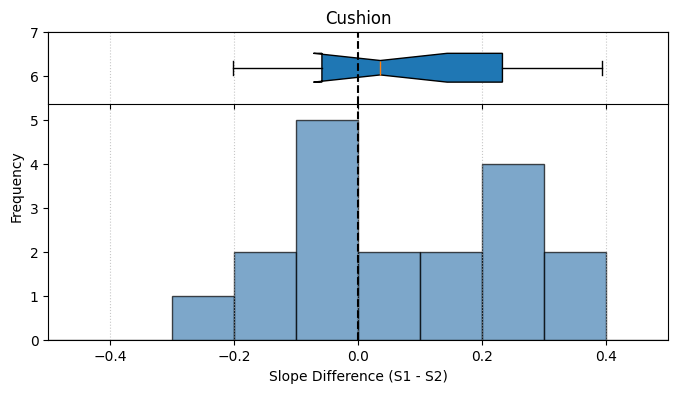

In [16]:
bp = 'total_rating_slope'
# create a list to hold slope differences for both methods
slopes_d1d2 = {}

# iterate over methods
for i, method in enumerate(['cushion', 'stretch']):    
    data_curr = full_slope_data[(full_slope_data['method'] == method) & (full_slope_data['study'] == 'Study 2') & (full_slope_data['significant'] == 'yes')]
    data1_curr = full_slope_data[(full_slope_data['method'] == method) & (full_slope_data['study'] == 'Study 1') & (full_slope_data['significant'] == 'yes')]
    # save slope differences for each method
    slopes_d1d2[method] = pd.DataFrame(data_curr['subject'].drop_duplicates().apply(lambda x: (data1_curr[data1_curr['subject'] == 'A'+x[1:]][bp].item() / 10) - (data_curr[data_curr['subject'] == x][bp].item() / 10)).reset_index(drop=True))
    # print(slopes_d1d2[method])

hist_bins = bins=np.arange(-0.5, 0.6, 0.1)

cushion_diff = slopes_d1d2['cushion']
print(cushion_diff)

plt.figure(figsize=(8, 4))
# plot a histogram of slope differences
plt.hist(cushion_diff, hist_bins, color='steelblue', edgecolor='black', alpha=0.7)
# set the x-axis limits to the first and last bin edges
plt.xlim(hist_bins[0], hist_bins[-1])
# turn grids on
plt.grid(axis='x', linestyle=':', alpha=0.7)
plt.xlabel('Slope Difference (S1 - S2)')
plt.ylabel('Frequency')
# increase y-axis limit to fit the highest bar
plt.ylim(0, 7)
# add a dashed line at x=0
plt.axvline(0, color='black', linestyle='--', linewidth=1.5)
# add title
plt.title('Cushion')

# create an axis that fits above the histogram
plt.axes([0.125, 0.7, 0.775, 0.18], sharex=plt.gca())
# plot a horizontal boxplot with notches above the histogram
plt.boxplot(cushion_diff, vert=False, patch_artist=True, notch=True, widths=0.4)
# set the x-axis limits to the first and last bin edges
plt.xlim(hist_bins[0], hist_bins[-1])
# remove x-tick labels
plt.tick_params(axis='x', labelbottom=False)
# remove y-tick labels
plt.yticks([])
# turn grids on
plt.grid(axis='x', linestyle=':', alpha=0.7)
# add a dashed line at x=0
plt.axvline(0, color='black', linestyle='--', linewidth=1.5)



     subject
0   0.203351
1   0.080096
2  -0.077338
3   0.262177
4   0.117819
5   0.022342
6   0.556401
7  -0.138327
8   0.146624
9   0.010383
10 -0.008033
11 -0.048145
12  0.047693
13  0.370807
14  0.214329
15 -0.286456
16  0.124496
17 -0.124702
18  0.176676
19  0.456243


(-0.5, 0.4999999999999998)

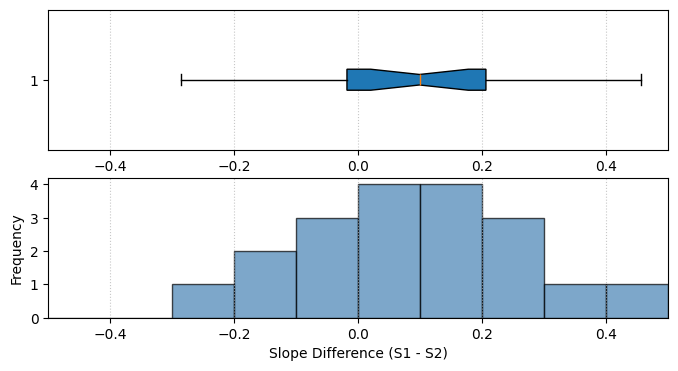

In [39]:
stretch_diff = slopes_d1d2['stretch']
print(stretch_diff)

# plot a horizontal boxplot with notches in a subplot
plt.figure(figsize=(8, 4))
plt.subplot(2, 1, 1)
plt.boxplot(stretch_diff, vert=False, patch_artist=True, notch=True)
# set the x-axis limits to the first and last bin edges
plt.xlim(hist_bins[0], hist_bins[-1])
# turn grids on
plt.grid(axis='x', linestyle=':', alpha=0.7)


# plot a histogram of slope differences
plt.subplot(2, 1, 2)
# plot a histogram of slope differences using bins from -0.5 to 0.5 in steps of 0.1
plt.hist(stretch_diff, hist_bins, color='steelblue', edgecolor='black', alpha=0.7)
# plt.title('Histogram of Slope Differences (Stretch)')
# set the x-axis limits to the first and last bin edges
plt.xlim(hist_bins[0], hist_bins[-1])
# turn grids on
plt.grid(axis='x', linestyle=':', alpha=0.7)
plt.xlabel('Slope Difference (S1 - S2)')
plt.ylabel('Frequency')

# get the x-axis limits of the second subplot
x_limits = plt.subplot(2, 1, 2).get_xlim()
# adjust the x-axis of the first subplot to match the second subplot
plt.subplot(2, 1, 1)
plt.xlim(x_limits)

In [40]:
print(hist_bins)

[-5.00000000e-01 -4.00000000e-01 -3.00000000e-01 -2.00000000e-01
 -1.00000000e-01 -1.11022302e-16  1.00000000e-01  2.00000000e-01
  3.00000000e-01  4.00000000e-01  5.00000000e-01]


## Body Part Slopes

In [10]:
def s1_s2_slope_bp():
    subplot_titles = []
    for col in ['Upper Back', 'Lower Back', 'pelvis_rating', 'butt_rating', 'upper_thigh_rating', 'lower_thigh_rating']:
        subplot_titles.append(f'Cushion {" ".join([x.capitalize() for x in col.split("_")])} Slope')
    for col in ['Upper Back', 'Lower Back', 'pelvis_rating', 'butt_rating', 'upper_thigh_rating', 'lower_thigh_rating']:
        subplot_titles.append(f'Stretch {" ".join([x.capitalize() for x in col.split("_")])} Slope')

    p_values = [[0.2324, 0.1014, 0.5325, 0.0164, 0.0147, 0.0332], [0.0467, 0.0065, 0.0267, 0.1206, 0.0175, 0.0199]]
    def add_plot(i, j, fig, slopes_d1d2, bp, p):
        def p_to_stars(p):
            return (('***' if p < 0.001 else '**') if p < 0.01 else '*') if p < 0.05 else ''

        if p_to_stars(p) == '':
            return
            
        y_max = slopes_d1d2['subject'].max()
        y_bar = y_max + 0.2
        
        fig.add_shape(type="line", x0=-0.2, x1=0.2, y0=y_bar, y1=y_bar, xref="x", yref="y", row=i+1, col=j+1, line=dict(color="black", width=2))
        fig.add_shape(type="line", x0=-0.2, x1=-0.2, y0=y_bar, y1=y_bar-0.1, xref="x", yref="y", row=i+1, col=j+1, line=dict(color="black", width=2))
        fig.add_shape(type="line", x0=0.2, x1=0.2, y0=y_bar-0.1, y1=y_bar, xref="x", yref="y", row=i+1, col=j+1, line=dict(color="black", width=2))
        fig.add_annotation(x=0, y=y_bar+0.1, text=p_to_stars(p), showarrow=False, xref="x", yref="y", row=i+1, col=j+1, font=dict(size=18))
    
    fig = make_subplots(rows=2, cols=6, subplot_titles=subplot_titles)
    
    for i, method in enumerate(['cushion', 'stretch']):    
        data_curr = full_slope_data[(full_slope_data['method'] == method) & (full_slope_data['study'] == 'Study 2') & (full_slope_data['significant'] == 'yes')]
        data1_curr = full_slope_data[(full_slope_data['method'] == method) & (full_slope_data['study'] == 'Study 1') & (full_slope_data['significant'] == 'yes')]
        
        for j, bp in enumerate(['Upper Back', 'Lower Back', 'pelvis_rating', 'butt_rating',  'upper_thigh_rating', 'lower_thigh_rating']):
            bp = f'{bp}_slope'

            slopes_d1d2 = pd.DataFrame(data_curr['subject'].drop_duplicates().apply(lambda x: data1_curr[data1_curr['subject'] == 'A'+x[1:]][bp].item() - data_curr[data_curr['subject'] == x][bp].item()).reset_index(drop=True))
            
            # fig.add_trace(go.Box(y=data1_curr[bp], name='Baseline study', marker_color=colors1[i], notched=True), row=i+1, col=j+1)
            # fig.add_trace(go.Box(y=data_curr[bp], name='Intervention study', marker_color=colors[i], notched=True), row=i+1, col=j+1)
            fig.add_trace(go.Box(y=slopes_d1d2['subject'], name='Baseline study', marker_color=colors[i], notched=True), row=i+1, col=j+1)
            add_plot(i, j, fig, slopes_d1d2, bp, p_values[i][j])
            
            fig.update_yaxes(title_text='Slope', row=i+1, col=j+1)
            fig.update_xaxes(title_text='Study', row=i+1, col=j+1)
    
            # print(f'{slopes_d1d2.shape} {method} {bp} {i} {j}')
            # mp.one_sample_plot(slopes_d1d2, f'subject', f'Difference in slopes (S1 - S2)', 0.5, xlabel='Difference in slopes (S1 - S2)')
    
    fig.update_yaxes(range=[-0.5, 1.2])
    fig.update_layout(height=800, width=2000, showlegend=False)
    fig.write_html("Figures/s1_s2_slope_bp.html")
    fig.show()

s1_s2_slope_bp()

# ['Upper Back', 'Lower Back', 'pelvis_rating', 'butt_rating', 'upper_thigh_rating', 'lower_thigh_rating']
# [[0.2324, 0.1014, 0.5325, 0.0164, 0.0147, 0.0332], [0.0467, *0.0065, 0.0267, 0.1206, *0.0175, *0.0199]]
# [[0.176,  0.312,  0.02,   0.548,  0.560,  0.463],  [0.395,  *0.612,  0.461,  0.270,  *0.507,  *0.494]]

## 2-hour slopes

In [11]:
def slope_7p(df, col, subject, a, b):
    times = [i for i in range(0, 121, 20)]
    times = [x / 60 for x in times]

    ratings = df[df['subject'] == subject]
    ratings = ratings[ratings['group'].between(a, b)][col]

    if len(ratings) != 7:
        print(len(ratings))
    
    return linregress(times, ratings).slope

def slope_2hrs_total():
    p_values = [[0.5313, 0.0990, 0.0876], [0.0049, 0.0195, 0.0505]]

    def add_plot(i, k, fig, slopes_d1d2, bp, p):
        def p_to_stars(p):
            return (('***' if p < 0.001 else '**') if p < 0.01 else '*') if p < 0.05 else ''

        if p_to_stars(p) == '':
            return
            
        y_max = slopes_d1d2['subject'].max()
        y_bar = y_max + 0.2
        x0, x1 = k - 0.3, k + 0.3
        
        fig.add_shape(type="line", x0=x0, x1=x1, y0=y_bar, y1=y_bar, xref="x", yref="y", row=1, col=i+1, line=dict(color="black", width=2))
        fig.add_shape(type="line", x0=x0, x1=x0, y0=y_bar, y1=y_bar-0.1, xref="x", yref="y", row=1, col=i+1, line=dict(color="black", width=2))
        fig.add_shape(type="line", x0=x1, x1=x1, y0=y_bar-0.1, y1=y_bar, xref="x", yref="y", row=1, col=i+1, line=dict(color="black", width=2))
        fig.add_annotation(x=(x0+x1)/2, y=y_bar * 1.02, text=p_to_stars(p), showarrow=False, xref="x", yref="y", row=1, col=i+1, font=dict(size=18))

    fig = make_subplots(rows=1, cols=2, subplot_titles=['Cushion Slope', 'Stretching Slope'])
    for i, method in enumerate(['cushion', 'stretch']):    
        d2 = full_rating_data[(full_rating_data['method'] == method) & (full_rating_data['study'] == 'Study 2') & (full_rating_data['significant'] == 'yes')]
        d1 = full_rating_data[(full_rating_data['method'] == method) & (full_rating_data['study'] == 'Study 1') & (full_rating_data['significant'] == 'yes')]

        bp = 'total_rating'
        for k in range(1, 4, 1):
            a = (7 * (k-1)) + 1
            b = a + 6

            slopes_d2 = d2['subject'].drop_duplicates().apply(lambda x: slope_7p(d2, bp, x, a, b))
            slopes_d1 = d1['subject'].drop_duplicates().apply(lambda x: slope_7p(d1, bp, x, a, b))
            slopes_d1d2 = pd.DataFrame(d2['subject'].drop_duplicates().apply(lambda x: (slope_7p(d1, bp, 'A'+x[1:], a, b) / 10) - (slope_7p(d2, bp, x, a, b) / 10)).reset_index(drop=True))
            
            subtitle = '0-2hrs' if k == 1 else ('2-4hrs' if k == 2 else '4-6hrs')
            # print(f'{slopes_d1d2.shape} {method} {bp} {k}')
            # mp.one_sample_plot(slopes_d1d2, f'subject', f'Difference in slopes (S1 - S2)', 0.5, xlabel='Difference in slopes (S1 - S2)')

            # fig.add_trace(go.Box(y=slopes_d1, name=f'Baseline {subtitle}', marker_color=colors1[i], notched=True), row=1, col=i+1)
            # fig.add_trace(go.Box(y=slopes_d2, name=f'Intervention {subtitle}', marker_color=colors[i], notched=True), row=1, col=i+1)
            fig.add_trace(go.Box(y=slopes_d1d2['subject'], name=f'Slope diff {subtitle}', marker_color=colors[i], notched=True), row=1, col=i+1)
            add_plot(i, k-1, fig, slopes_d1d2, bp, p_values[i][k-1])

        fig.update_yaxes(title_text='Slope', row=1, col=i+1)
        fig.update_xaxes(title_text='Study', row=1, col=i+1)
    
    fig.update_yaxes(range=[-1.2, 2])
    fig.update_layout(height=800, width=2000, showlegend=False)#True)
    fig.show()
    
    fig.write_html("Figures/2_hr_chunks_total.html")

slope_2hrs_total()

## 2-hour body part slopes

In [12]:
def slope_2hrs_bp():
    p_values = [[[0.6580, 0.4819, 0.0503], [0.5953, 0.3338, 0.3350], [0.4441, 0.1611, 0.3607], [0.5240, 0.0742, 0.0528], [0.5937, 0.1413, 0.0988], [0.4828, 0.0965, 0.0958]],
                [[0.0057, 0.2661, 0.1653], [0.0340, 0.0440, 0.1297], [0.0147, 0.0126, 0.2135], [0.0048, 0.0040, 0.1139], [0.0113, 0.1688, 0.0610], [0.0057, 0.1482, 0.0328]]]

    def add_plot(i, j, k, fig, slopes_d1d2, bp, p):
        def p_to_stars(p):
            return (('***' if p < 0.001 else '**') if p < 0.01 else '*') if p < 0.05 else ''

        if p_to_stars(p) == '':
            return
            
        y_max = slopes_d1d2['subject'].max()
        y_bar = y_max + 0.2
        x0, x1 = k - 0.25, k + 0.25
        
        fig.add_shape(type="line", x0=x0, x1=x1, y0=y_bar, y1=y_bar, xref="x", yref="y", row=i+1, col=j+1, line=dict(color="black", width=2))
        fig.add_shape(type="line", x0=x0, x1=x0, y0=y_bar, y1=y_bar-0.1, xref="x", yref="y", row=i+1, col=j+1, line=dict(color="black", width=2))
        fig.add_shape(type="line", x0=x1, x1=x1, y0=y_bar-0.1, y1=y_bar, xref="x", yref="y", row=i+1, col=j+1, line=dict(color="black", width=2))
        fig.add_annotation(x=(x0+x1)/2, y=y_bar * 1.02, text=p_to_stars(p), showarrow=False, xref="x", yref="y", row=i+1, col=j+1, font=dict(size=18))

    subplot_titles = []
    for col in ['Upper Back', 'Lower Back', 'pelvis_rating', 'butt_rating', 'upper_thigh_rating', 'lower_thigh_rating']:
        subplot_titles.append(f'Cushion {" ".join([x.capitalize() for x in col.split("_")])} Slope')
    for col in ['Upper Back', 'Lower Back', 'pelvis_rating', 'butt_rating', 'upper_thigh_rating', 'lower_thigh_rating']:
        subplot_titles.append(f'Stretch {" ".join([x.capitalize() for x in col.split("_")])} Slope')
     
    fig = make_subplots(rows=2, cols=6, subplot_titles=subplot_titles)
    for i, method in enumerate(['cushion', 'stretch']):    
        d2 = full_rating_data[(full_rating_data['method'] == method) & (full_rating_data['study'] == 'Study 2') & (full_rating_data['significant'] == 'yes')]
        d1 = full_rating_data[(full_rating_data['method'] == method) & (full_rating_data['study'] == 'Study 1') & (full_rating_data['significant'] == 'yes')]
    
        for j, bp in enumerate(['Upper Back', 'Lower Back', 'pelvis_rating', 'butt_rating',  'upper_thigh_rating', 'lower_thigh_rating']):
            for k in range(1, 4, 1):
                a = (7 * (k-1)) + 1
                b = a + 6
    
                slopes_d2 = d2['subject'].drop_duplicates().apply(lambda x: slope_7p(d2, bp, x, a, b))
                slopes_d1 = d1['subject'].drop_duplicates().apply(lambda x: slope_7p(d1, bp, x, a, b))
                slopes_d1d2 = pd.DataFrame(d2['subject'].drop_duplicates().apply(lambda x: slope_7p(d1, bp, 'A'+x[1:], a, b) - slope_7p(d2, bp, x, a, b)).reset_index(drop=True))
                
                subtitle = '0-2hrs' if k == 1 else ('2-4hrs' if k == 2 else '4-6hrs')
                # print(f'{slopes_d1d2.shape} {method} {bp} {k}')
                # mp.one_sample_plot(slopes_d1d2, f'subject', f'Difference in slopes (S1 - S2)', 0.5, xlabel='Difference in slopes (S1 - S2)')
    
                # fig.add_trace(go.Box(y=slopes_d1, name=f'Baseline {subtitle}', marker_color=colors1[i], notched=True), row=i+1, col=j+1)
                # fig.add_trace(go.Box(y=slopes_d2, name=f'Intervention {subtitle}', marker_color=colors[i], notched=True), row=i+1, col=j+1)
                fig.add_trace(go.Box(y=slopes_d1d2['subject'], name=f'Slope diff {subtitle}', marker_color=colors[i], notched=True), row=i+1, col=j+1)
                add_plot(i, j, k-1, fig, slopes_d1d2, bp, p_values[i][j][k-1])
    
            fig.update_yaxes(title_text='Slope', row=i+1, col=j+1)
            fig.update_xaxes(title_text='Study', row=i+1, col=j+1)
    
    fig.update_yaxes(range=[-1.5, 2.5])
    fig.update_layout(height=800, width=2500, showlegend=False)#True)
    fig.show()
    fig.write_html("Figures/2_hr_chunks_bp.html")

slope_2hrs_bp()

# ['Upper Back', 'Lower Back', 'pelvis_rating', 'butt_rating', 'upper_thigh_rating', 'lower_thigh_rating']

# [[0.5313, 0.0990, 0.0876], [0.0049, 0.0195, 0.0505]]
# [[0.019, 0.316, 0.334], [0.642, 0.496, 0.385]]

# [[[0.6580, 0.4819, 0.0503], [0.5953, 0.3338, 0.3350], [0.4441, 0.1611, 0.3607],  [0.5240, 0.0742, 0.0528], [0.5937, 0.1413, 0.0988], [0.4828, 0.0965, 0.0958]],
#  [[0.0057, 0.2661, 0.1653], [0.0340, 0.0440, 0.1297], [*0.0147, 0.0126, 0.2135], [0.0048, 0.0040, 0.1139], [0.0113, 0.1688, 0.0610], [0.0057, 0.1482, 0.0328]]]

# [[[0.098,  0.011,  0.409],  [0.058,  0.103,  0.089],  [0.034,  0.240,  0.085],  [0.014,  0.357,  0.403],  [0.057,  0.262,  0.316],  [0.010,  0.319,  0.321]],
#  [[0.627,  0.142,  0.223],  [0.433,  0.402,  0.260],  [0.526,  0.543,  0.182],  [0.643,  0.663,  0.279],  [0.555,  0.220,  0.362],  [0.626,  0.240,  0.437]]]


## Total Rating Intervention Comparison

In [13]:
def intervention_comparison_total():
    fig = make_subplots(rows=1, cols=1, subplot_titles=['Difference between the Study 1 and Study 2 Slope (S1 - S2)'])
    bp = 'total_rating_slope'

    data = []
    for i, method in enumerate(['cushion', 'stretch']):    
        data1_curr = full_slope_diff_data[(full_slope_diff_data['method'] == method) & (full_slope_diff_data['significant'] == 'yes')]
        data.append(data1_curr[f'{bp}_diff'])
        fig.add_trace(go.Histogram(x=data1_curr[f'{bp}_diff'], name=f'S1 - S2 ({method})', marker_color=colors[i], opacity=0.4,
                                   xbins=dict(start=-5, end=12, size=0.5)), row=1, col=1)

        mean_curr = np.mean(data1_curr[f'{bp}_diff'])

        fig.add_trace(go.Scatter(x=[mean_curr, mean_curr], y=[0, 130], mode='lines', line=dict(color=colors[i], dash='dash'),
                                 showlegend=False), row=1, col=1)

    if np.mean(data[0]) < np.mean(data[1]):
        fig.add_annotation(x=np.mean(data[0]), y=3.1, text=f'{np.mean(data[0]):.1f} points/hr ', font=dict(color=colors[0], size=10), showarrow=False, xanchor='right', yanchor='middle', row=1, col=1)
        fig.add_annotation(x=np.mean(data[1]), y=3.1, text=f' {np.mean(data[1]):.1f} points/hr', font=dict(color=colors[1], size=10), showarrow=False, xanchor='left', yanchor='middle', row=1, col=1)
    else:
        fig.add_annotation(x=np.mean(data[0]), y=3.1, text=f'{np.mean(data[0]):.1f} points/hr ', font=dict(color=colors[0], size=10), showarrow=False, xanchor='left', yanchor='middle', row=1, col=1)
        fig.add_annotation(x=np.mean(data[1]), y=3.1, text=f' {np.mean(data[1]):.1f} points/hr', font=dict(color=colors[1], size=10), showarrow=False, xanchor='right', yanchor='middle', row=1, col=1)

    # mp.two_sample_plot(data[1], "Stretch",  data[0], "Cushion", 0.5)
    
    fig.update_layout(height=700, width=800, showlegend=False, barmode='overlay')
    
    fig.update_xaxes(range=[-3.5, 6.5], title_text='Points/hour', dtick=1)
    fig.update_yaxes(range=[0, 3.2], title_text='Count', dtick=1)
    fig.write_html("Figures/intervention_comparison_total.html")
    fig.show()

intervention_comparison_total()

## Body Part Rating Intervention Comparison

In [14]:
def intervention_comparison_bp():
    subplot_titles = []
    for col in ['Upper Back', 'Lower Back', 'pelvis_rating', 'butt_rating', 'upper_thigh_rating', 'lower_thigh_rating']:
        subplot_titles.append(f'Difference in the Study 1 and Study 2 {" ".join([x.capitalize() for x in col.split("_")])} Slope')
        
    fig = make_subplots(rows=1, cols=6, subplot_titles=subplot_titles)
    for j, bp in enumerate(['Upper Back', 'Lower Back', 'pelvis_rating', 'butt_rating',  'upper_thigh_rating', 'lower_thigh_rating']):
        data = []
        for i, method in enumerate(['cushion', 'stretch']):    
            data1_curr = full_slope_diff_data[full_slope_diff_data['method'] == method]
            data.append(data1_curr[f'{bp}_slope_diff'])
            
            fig.add_trace(go.Histogram(x=data1_curr[f'{bp}_slope_diff'], name=f'S1 - S2 ({method})', marker_color=colors[i], opacity=0.4,
                                       xbins=dict(start=-5, end=12, size=0.5)), row=1, col=j+1)
    
            mean_curr = np.mean(data1_curr[f'{bp}_slope_diff'])
    
            fig.add_trace(go.Scatter(x=[mean_curr, mean_curr], y=[0, 130], mode='lines', line=dict(color=colors[i], dash='dash'),
                                     showlegend=False), row=1, col=j+1)

            fig.update_xaxes(range=[-0.6, 1.6], title_text='Points/hour', dtick=0.5, row=i+1, col=j+1)
            fig.update_yaxes(range=[0, 16.3], title_text='Count', dtick=2, row=i+1, col=j+1)
    
        if np.mean(data[0]) < np.mean(data[1]):
            fig.add_annotation(x=np.mean(data[0]), y=16.1, text=f'{np.mean(data[0]):.2f} points/hr  ', font=dict(color=colors[0], size=10), showarrow=False, xanchor='right', yanchor='middle', row=1, col=j+1)
            fig.add_annotation(x=np.mean(data[1]), y=16.1, text=f'  {np.mean(data[1]):.2f} points/hr', font=dict(color=colors[1], size=10), showarrow=False, xanchor='left', yanchor='middle', row=1, col=j+1)
        else:
            fig.add_annotation(x=np.mean(data[0]), y=16.1, text=f'{np.mean(data[0]):.2f} points/hr  ', font=dict(color=colors[0], size=10), showarrow=False, xanchor='left', yanchor='middle', row=1, col=j+1)
            fig.add_annotation(x=np.mean(data[1]), y=16.1, text=f'  {np.mean(data[1]):.2f} points/hr', font=dict(color=colors[1], size=10), showarrow=False, xanchor='right', yanchor='middle', row=1, col=j+1)

        # mp.two_sample_plot(data[1], "Stretch",  data[0], "Cushion", 0.5)
    
    fig.update_layout(height=700, width=4000, showlegend=False, barmode='overlay')
    fig.write_html("Figures/intervention_comparison_bp.html")
    fig.show()

intervention_comparison_bp()

# Anthropometric effects on the slope

In [15]:
data1_anthro = pd.read_csv('Data/anthro.csv')
data1_anthro['sig'] = data1_anthro.apply(lambda x: "not-significant" if x['subject'] in ['A052', 'A053', 'A109', 'A194', 'A198', 'A118'] else "significant", axis=1)
data1_anthro['BMI'] = data1_anthro .apply(lambda x: 33.42 if x['subject'] == 'A204' else x['BMI'], axis=1)
data1_anthro['subject_s2'] = data1_anthro['subject'].apply(lambda x: 'B'+x[1:])

## Total / Body-part Ratings with significant p-values

In [16]:
sdg = {'6 to 9 hours':'6-9', '3 to 6 hours':'3-6', '0 to 3 hours':'0-3'}
pfg = {'<=5':'less5', '>5':'more5'}
depcols = ['total_rating_slope', 'Upper Back_slope', 'Lower Back_slope', 'pelvis_rating_slope', 'butt_rating_slope', 
          'upper_thigh_rating_slope', 'lower_thigh_rating_slope', 'total_rating_slope_diff', 'Upper Back_slope_diff', 
          'Lower Back_slope_diff', 'pelvis_rating_slope_diff', 'butt_rating_slope_diff', 'upper_thigh_rating_slope_diff', 
          'lower_thigh_rating_slope_diff']
way = ['ols', 'spearman'][0]

data = data1_anthro.merge(full_slope_diff_data, on='subject').merge(full_slope_data[full_slope_data['study'] == 'Study 2'], left_on='subject_s2', right_on='subject')
data = data.rename(columns={'subject_x':'subject', 'method_x':'method'})

## Numerical variables
for depcol in depcols:
    for col in ['Weight', 'Age', 'BMI', 'Height', 'Gender']:
        for method in ['both', 'cushion', 'stretch']:
            curr_data = data.copy()[[depcol, 'sig', 'method', col]].dropna()
            curr_data = curr_data[curr_data['sig'] == 'significant']
            if method != 'both':
                curr_data = curr_data[curr_data['method'] == method]
    
            if way == 'ols':
                model = smf.ols(formula=f'Q("{depcol}") ~ Q("{col}")', data=curr_data).fit()
                if model.pvalues[1] <= 0.05:
                    print(f'{method} {col} {depcol} {len(curr_data)} {model.pvalues[1]:.2f}')
                    
            elif way == 'spearman':
                corr, pval = spearmanr(curr_data[col], curr_data[depcol])
                if pval <= 0.05:
                    print(f"Spearman correlation: {corr:.2f} p-value: {pval:.2f}")

## Gender
for depcol in depcols:
    for method in ['cushion', 'stretch']:
        curr_data = data.copy()[[depcol, 'sig', 'method', 'Gender']].dropna()
        curr_data = curr_data[(curr_data['sig'] == 'significant') & (curr_data['method'] == method)]
        
        group1 = curr_data[curr_data['Gender']=='Male'][depcol]
        group2 = curr_data[curr_data['Gender']=='Female'][depcol]
        
        stat, pval = mannwhitneyu(curr_data[curr_data['Gender']=='Male'][depcol], 
                                  curr_data[curr_data['Gender']=='Female'][depcol], alternative='two-sided')
        if pval <= 0.05:
            print(f"Mann-Whitney U: {stat:.2f} p-value: {pval:.2f}")

## Sitting Duration
for depcol in depcols:
    for method in ['cushion', 'stretch']:
        curr_data = data.copy()[[depcol, 'sig', 'method', 'sitting_duration']].dropna()
        curr_data = curr_data[(curr_data['sig'] == 'significant') & (curr_data['method'] == method)]
        
        curr_data['sitting_duration'] = curr_data['sitting_duration'].apply(lambda x: '6 to 9 hours' if x == 'More than 9 hours' else x)
        groups = [curr_data[curr_data['sitting_duration'] == g][depcol] for g in curr_data['sitting_duration'].unique()]
        stat, pval = kruskal(*groups)

        if pval <= 0.05:
            print(f"Kruskal-Wallis: {stat:.2f} p-value: {pval:.2f}")


## Plot demographic values against the difference in the slope

In [17]:
fig = make_subplots(rows=3, cols=7)
colors = ['black', 'steelblue', 'darkorange']
custom_order = {"Gender": ["Male", "Female"], "past_flights": ["0", "1 to 5", "6 to 15", "More than 15"],
    "sitting_duration": ["0 to 3 hours", "3 to 6 hours", "6 to 9 hours", "More than 9 hours"]}
custom_order2 = {"Gender": ["Male", "Female"], "past_flights": ["0", "1-5", "6-15", "> 15"], "sitting_duration": ["0-3 hrs", "3-6 hrs", "6-9 hrs", "> 9 hrs"]}

for i, method in enumerate(['both', 'cushion', 'stretch']):    
    data_curr = data1_anthro.merge(full_slope_diff_data, on='subject').merge(full_slope_data[full_slope_data['study'] == 'Study 2'], left_on='subject_s2', right_on='subject')
    data1_curr = data1_anthro.merge(full_slope_diff_data, on='subject').merge(full_slope_data[full_slope_data['study'] == 'Study 1'], left_on='subject', right_on='subject')
    if i != 0:
        data_curr = data_curr[data_curr['method_x'] == method]
        data1_curr = data1_curr[data1_curr['method_x'] == method]

    data_curr = data_curr[data_curr['significant_x'] == 'yes']
    data1_curr = data1_curr[data1_curr['significant_x'] == 'yes']

    depcol = depcols[0]
    for j, ant in enumerate(['Age', 'BMI', 'Weight', 'Height', 'Gender', 'sitting_duration', 'past_flights']):
        if j < 4: 
            x = data_curr[ant]
            y = data_curr[depcol]

            fig.add_trace(go.Scatter(x=x, y=y, mode='markers', marker=dict(color=colors[i]), opacity=0.5), row=i+1, col=j+1)

            slope, intercept = np.polyfit(x, y, 1)
            x_line = np.array([x.min(), x.max()])
            y_line = slope * x_line + intercept
            fig.add_trace(go.Scatter(x=x_line, y=y_line, mode='lines', line=dict(color=colors[i], dash='dash')), row=i+1, col=j+1)
        
        else:
            cat_order = custom_order[ant]
            
            data1_curr[ant] = pd.Categorical(data1_curr[ant], categories=custom_order[ant], ordered=True)
            data_sorted = data1_curr.sort_values(by=ant)
            x_cat = data_sorted[ant]
            y_values = data_sorted[depcol]
            
            fig.add_trace(go.Box(x=x_cat, y=data1_curr[depcol], marker_color=colors[i], boxmean=False, opacity=0.5), row=i+1, col=j+1)
            
            fig.add_trace(go.Scatter(x=x_cat, y=y_values, mode='markers', marker=dict(color=colors[i]), opacity=0.4),row=i+1, col=j+1)
            fig.update_xaxes(tickvals=cat_order, ticktext=custom_order2[ant], tickangle=0, row=i+1, col=j+1)
            
        if i == 2:
            fig.update_xaxes(title_text=f'{" ".join([x.capitalize() for x in ant.split("_")])}', row=i+1, col=j+1)

        if j == 0:
            fig.update_yaxes(title_text=f'Diff in the slope ({method})', row=i+1, col=j+1)

fig.update_yaxes(range=[0, 10])
fig.update_layout(height=800, width=2000, showlegend=False)
fig.show()
fig.write_html("Figures/demographics.html")

## Population differences between S1 and S2 for both gender groups

109


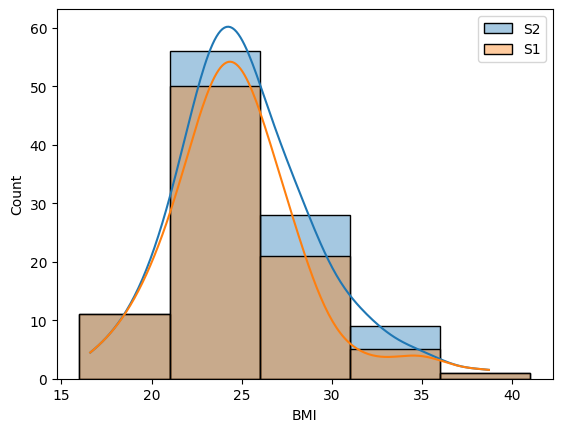

Mean: S2: 25.239 S1: 24.761
Median: S2: 24.700 S1: 24.450
Hypothesis test
Non-normal distribution... Using Kruskal and Dunn posthoc tests...
0.3817558536255502
No significant difference...
Effect size 0.125


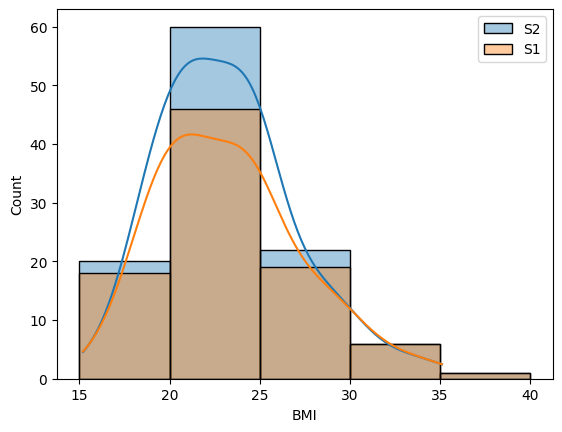

Mean: S2: 23.164 S1: 23.292
Median: S2: 22.700 S1: 22.900
Hypothesis test
Non-normal distribution... Using Kruskal and Dunn posthoc tests...
0.9172610053495227
No significant difference...
Effect size -0.033


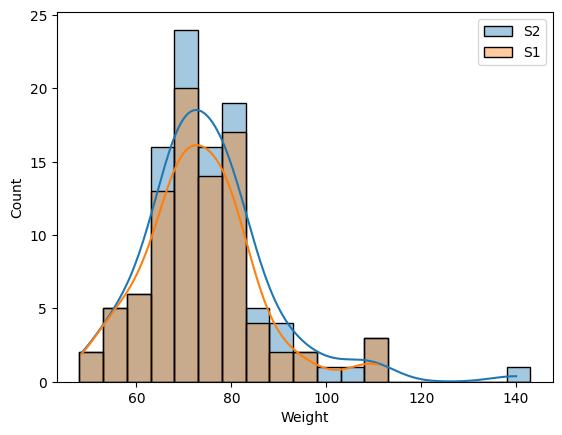

Mean: S2: 74.918 S1: 73.423
Median: S2: 72.300 S1: 71.650
Hypothesis test
Non-normal distribution... Using Kruskal and Dunn posthoc tests...
0.5718206781624577
No significant difference...
Effect size 0.117


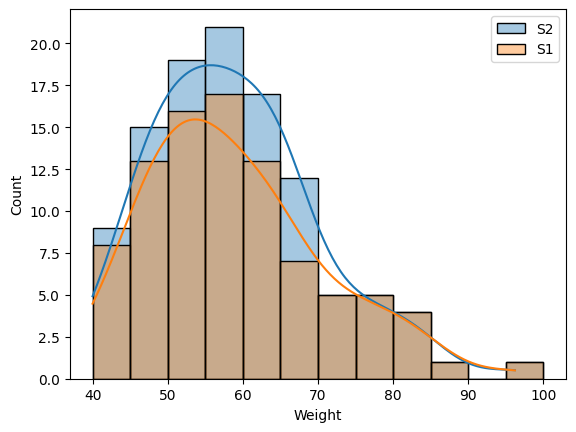

Mean: S2: 58.949 S1: 59.018
Median: S2: 57.500 S1: 56.750
Hypothesis test
Non-normal distribution... Using Kruskal and Dunn posthoc tests...
0.8830066906133114
No significant difference...
Effect size -0.006


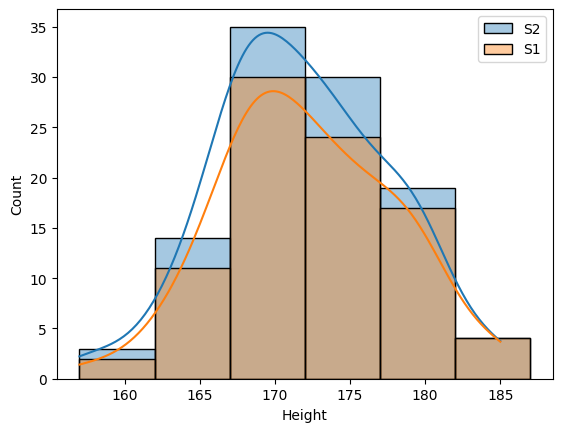

Mean: S2: 171.810 S1: 172.136
Median: S2: 172.000 S1: 172.000
Hypothesis test
Normal distribution and equal variance... Using Anova and Tukey tests...
0.6934657365695893
No significant difference...
Effect size -0.057


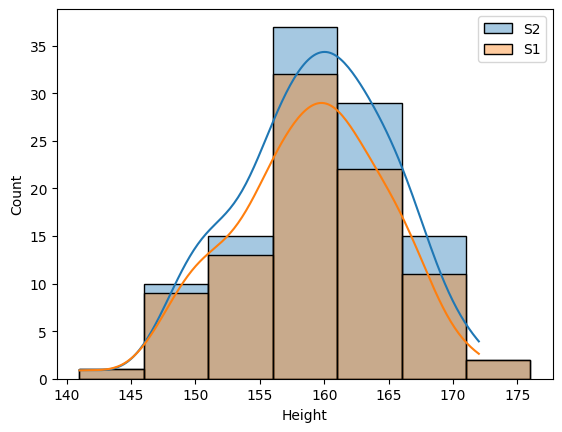

Mean: S2: 159.261 S1: 158.882
Median: S2: 160.000 S1: 160.000
Hypothesis test
Normal distribution and equal variance... Using Anova and Tukey tests...
0.6526066842777724
No significant difference...
Effect size 0.064


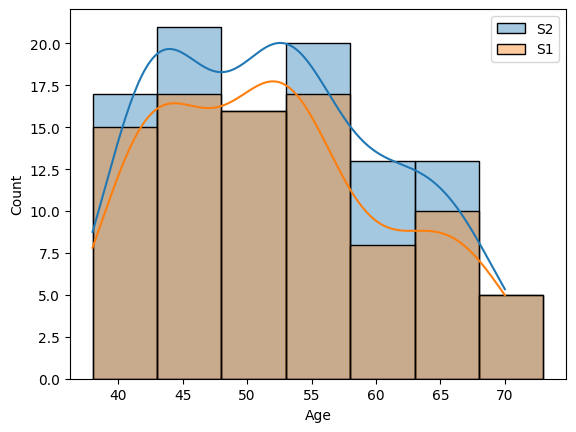

Mean: S2: 52.324 S1: 52.034
Median: S2: 52.000 S1: 52.000
Hypothesis test
Non-normal distribution... Using Kruskal and Dunn posthoc tests...
0.7896467953838343
No significant difference...
Effect size 0.033


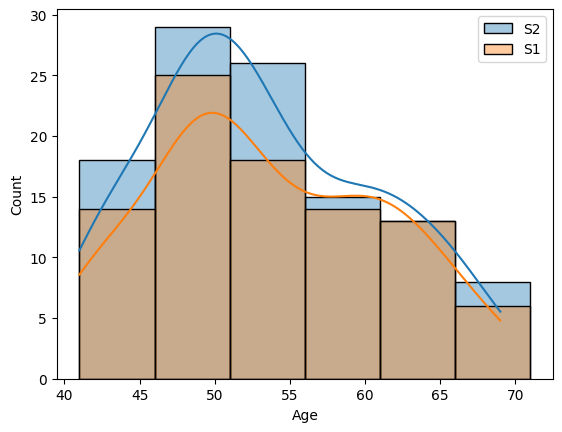

Mean: S2: 53.119 S1: 53.511
Median: S2: 52.000 S1: 52.500
Hypothesis test
Non-normal distribution... Using Kruskal and Dunn posthoc tests...
0.7306737762165376
No significant difference...
Effect size -0.052


In [18]:
anthro1 = pd.read_excel('Data/df_ratings_all_std.xlsx').sort_values(by="slope_hour", ascending=False).head(178)
anthro1['BMI'] = anthro1.apply(lambda x: 33.42 if x['subject'] == 'A204' else x['BMI'], axis=1)

anthro2 = data1_anthro.copy()
anthro2['BMI'] = anthro2.apply(lambda x: 33.42 if x['subject_s2'] == 'B204' else x['BMI'], axis=1)

anthro_female_s1 = anthro1[anthro1['Gender'] == 'Female']
anthro_male_s1 = anthro1[anthro1['Gender'] == 'Male']
anthro_female_s2 = anthro2[anthro2['Gender'] == 'Female']
anthro_male_s2 = anthro2[anthro2['Gender'] == 'Male']

print(len(anthro_female_s2))

for col in ['BMI', 'Weight', 'Height', 'Age']:
    mp.two_sample_plot(anthro_male_s2[col], "S2",  anthro_male_s1[col], "S1", 5)
    mp.two_sample_plot(anthro_female_s2[col], "S2",  anthro_female_s1[col], "S1", 5)

# Other Analysis

## Median Ratings

Cushion total_rating: S2 -> 4.16 points/hour & R2 = 0.87 + S1 -> 4.90 points/hour & R2 = 0.96
Stretch total_rating: S2 -> 3.37 points/hour & R2 = 0.96 + S1 -> 5.09 points/hour & R2 = 0.97
Cushion Upper Back: S2 -> 0.33 points/hour & R2 = 0.79 + S1 -> 0.47 points/hour & R2 = 0.90
Cushion Lower Back: S2 -> 0.49 points/hour & R2 = 0.85 + S1 -> 0.58 points/hour & R2 = 0.89
Cushion pelvis_rating: S2 -> 0.50 points/hour & R2 = 0.89 + S1 -> 0.51 points/hour & R2 = 0.88
Cushion butt_rating: S2 -> 0.51 points/hour & R2 = 0.85 + S1 -> 0.62 points/hour & R2 = 0.92
Cushion upper_thigh_rating: S2 -> 0.38 points/hour & R2 = 0.82 + S1 -> 0.51 points/hour & R2 = 0.93
Cushion lower_thigh_rating: S2 -> 0.34 points/hour & R2 = 0.83 + S1 -> 0.42 points/hour & R2 = 0.93
Stretch Upper Back: S2 -> 0.36 points/hour & R2 = 0.82 + S1 -> 0.46 points/hour & R2 = 0.90
Stretch Lower Back: S2 -> 0.41 points/hour & R2 = 0.88 + S1 -> 0.60 points/hour & R2 = 0.92
Stretch pelvis_rating: S2 -> 0.39 points/hour & R2 = 0.8

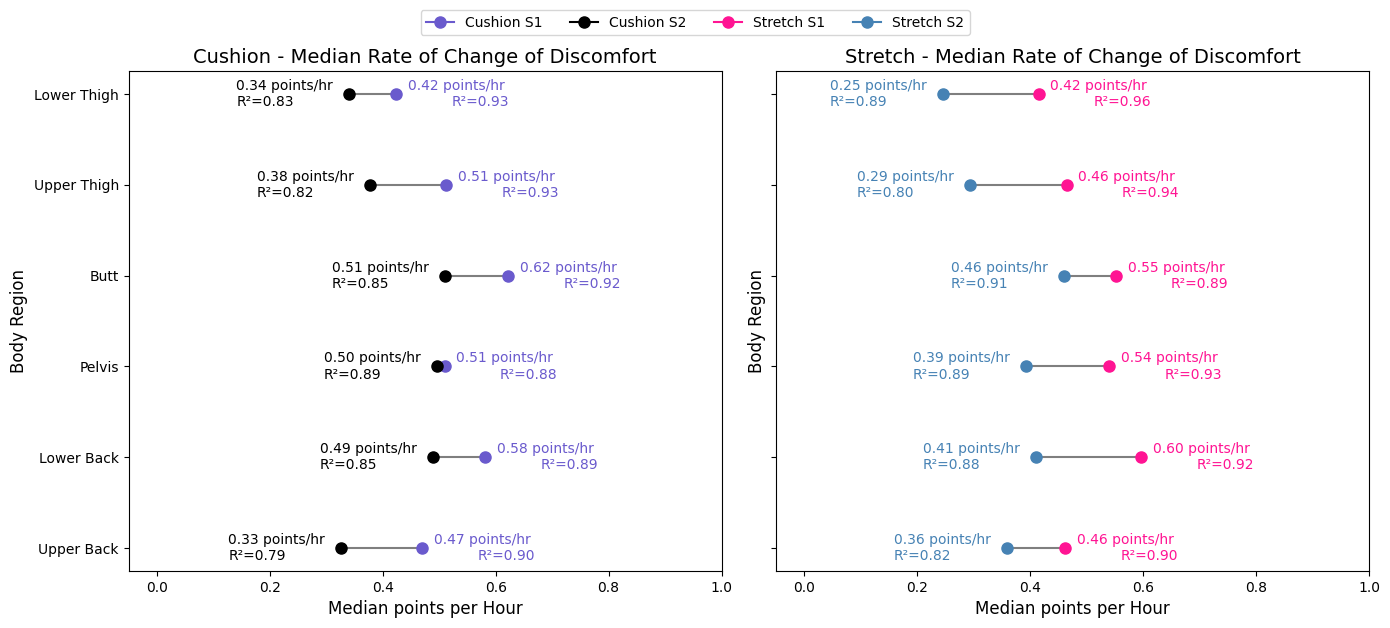

In [19]:
def slope_median(df, col):
    times = [i for i in range(0, 121, 20)]
    times.extend([i for i in range(145, 248, 20)])
    times.extend([i for i in range(270, 375, 20)])
    times = [x / 60 for x in times]

    ratings = [np.median(df[df['group'] == i][col]) for i in range(1,22,1) if i not in [8, 15]]
    return linregress(times, ratings).slope, linregress(times, ratings).rvalue ** 2

def slope_median_all():
    S2_slope_cs, S2_R2_cs, S1_slope_cs, S1_R2_cs = [], [], [], []

    for met in ['cushion', 'stretch']:
        s2_slope, s2_r2 = slope_median(full_rating_data[(full_rating_data['method'] == met) & (full_rating_data['study'] == 'Study 2')], 'total_rating')
        s1_slope, s1_r2 = slope_median(full_rating_data[(full_rating_data['method'] == met) & (full_rating_data['study'] == 'Study 1')], 'total_rating')
        print(f"{met.capitalize()} total_rating: S2 -> {s2_slope:.2f} points/hour & R2 = {s2_r2:.2f} + S1 -> {s1_slope:.2f} points/hour & R2 = {s1_r2:.2f}")

    
    for met in ['cushion', 'stretch']:
        S2_slope_curr, S2_R2_curr, S1_slope_curr, S1_R2_curr = [], [], [], []
        for col in all_rating_columns:
            s2_slope, s2_r2 = slope_median(full_rating_data[(full_rating_data['method'] == met) & (full_rating_data['study'] == 'Study 2')], col)
            s1_slope, s1_r2 = slope_median(full_rating_data[(full_rating_data['method'] == met) & (full_rating_data['study'] == 'Study 1')], col)
    
            print(f"{met.capitalize()} {col}: S2 -> {s2_slope:.2f} points/hour & R2 = {s2_r2:.2f} + S1 -> {s1_slope:.2f} points/hour & R2 = {s1_r2:.2f}")

            S2_slope_curr.append(s2_slope)
            S2_R2_curr.append(s2_r2)
            S1_slope_curr.append(s1_slope)
            S1_R2_curr.append(s1_r2)
            
        S2_slope_cs.append(S2_slope_curr)
        S2_R2_cs.append(S2_R2_curr)
        S1_slope_cs.append(S1_slope_curr)
        S1_R2_cs.append(S1_R2_curr)

    regions = ['Upper Back', 'Lower Back', 'Pelvis', 'Butt', 'Upper Thigh', 'Lower Thigh']
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    
    for j, method in enumerate(['Cushion', 'Stretch']):
        for i in range(len(regions)):
            axs[j].plot([S1_slope_cs[j][i], S2_slope_cs[j][i]], [i, i], marker='o', color='black', markersize=5, alpha=0.5)
            axs[j].plot(S1_slope_cs[j][i], i, marker='o', color=colors1[j], markersize=8, label=f'{method} S1' if i == 0 else "")
            axs[j].plot(S2_slope_cs[j][i], i, marker='o', color=colors[j], markersize=8, label=f'{method} S2' if i == 0 else "")
        
            axs[j].text(S1_slope_cs[j][i] + 0.2, i, f'{S1_slope_cs[j][i]:.2f} points/hr \nR²={S1_R2_cs[j][i]:.2f}', 
                        va='center', color=colors1[j], fontsize=10, ha='right')
            axs[j].text(S2_slope_cs[j][i] - 0.2, i, f'{S2_slope_cs[j][i]:.2f} points/hr \nR²={S2_R2_cs[j][i]:.2f}', 
                        va='center', color=colors[j], fontsize=10, ha='left')
    
            axs[j].set_xlabel('Median points per Hour', fontsize=12)
            axs[j].set_ylabel('Body Region', fontsize=12)
            axs[j].set_title(f'{method} - Median Rate of Change of Discomfort', fontsize=14)
            axs[j].set_yticks(range(len(regions)))
            axs[j].set_yticklabels(regions, fontsize=10)
            axs[j].set_xlim(-0.05, 1)
    
    fig.legend(loc='upper center', fontsize=10, bbox_to_anchor=(0.5, 1.05), ncol=4)
    plt.tight_layout()
    plt.show()

slope_median_all()

## Slope median 3

Cushion total_rating (1): S2 -> 10.29 points/hour & R2 = 0.98 + S1 -> 6.64 points/hour & R2 = 0.99
Cushion total_rating (2): S2 -> 7.98 points/hour & R2 = 0.98 + S1 -> 9.75 points/hour & R2 = 0.91
Cushion total_rating (3): S2 -> 4.55 points/hour & R2 = 0.88 + S1 -> 5.68 points/hour & R2 = 0.86
Stretch total_rating (1): S2 -> 2.46 points/hour & R2 = 0.83 + S1 -> 4.50 points/hour & R2 = 0.94
Stretch total_rating (2): S2 -> 6.38 points/hour & R2 = 0.87 + S1 -> 9.54 points/hour & R2 = 0.96
Stretch total_rating (3): S2 -> 3.48 points/hour & R2 = 0.80 + S1 -> 6.54 points/hour & R2 = 0.93


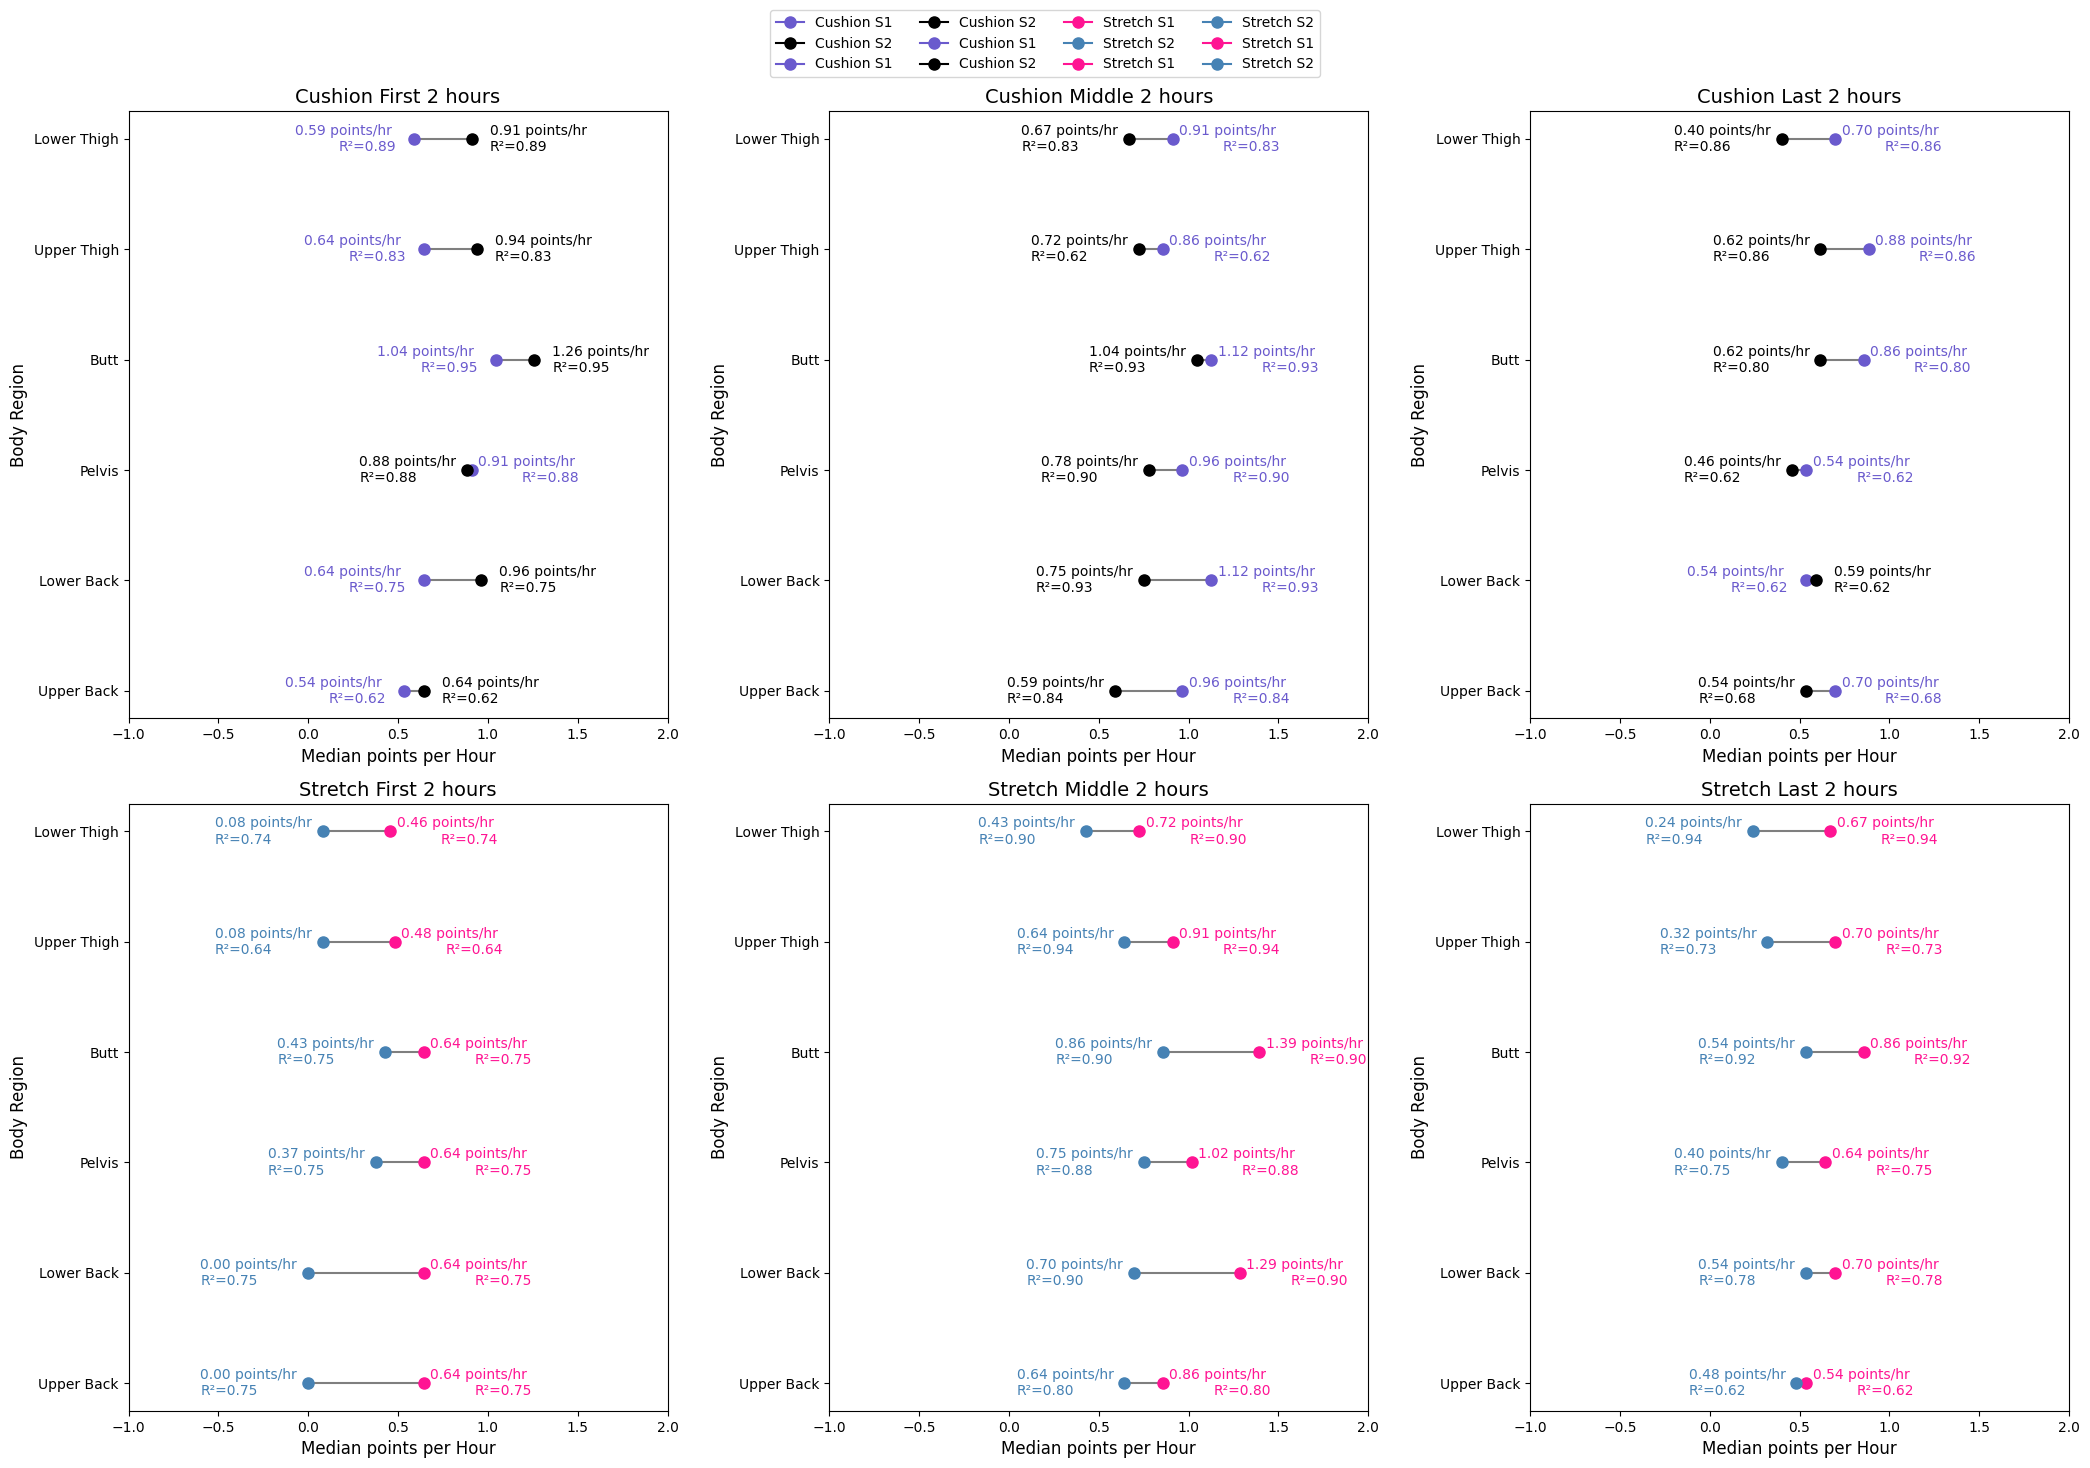

In [20]:
def slope_3(df, col, a, b):
    times = [i for i in range(0, 121, 20)]
    times = [x / 60 for x in times]

    ratings = [np.median(df[df['group'] == i][col]) for i in range(a,b+1,1)]

    if len(ratings) != 7:
        print(len(ratings))
        
    return linregress(times, ratings).slope, linregress(times, ratings).rvalue ** 2

def slope_median_3():
    regions = ['Upper Back', 'Lower Back', 'Pelvis', 'Butt', 'Upper Thigh', 'Lower Thigh']
    S1_slope_cs_123, S2_slope_cs_123, S1_R2_cs_123, S2_R2_cs_123 = [[[], [], []], [[], [], []]], [[[], [], []], [[], [], []]], [[[], [], []], [[], [], []]], [[[], [], []], [[], [], []]]

    for j, met in enumerate(['cushion', 'stretch']):
        for i in range(1, 4, 1):
            a = (7 * (i-1)) + 1
            b = a + 6
                
            s2_slope, s2_r2 = slope_3(full_rating_data[(full_rating_data['method'] == met) & (full_rating_data['study'] == 'Study 2')], 'total_rating', a, b)
            s1_slope, s1_r2 = slope_3(full_rating_data[(full_rating_data['method'] == met) & (full_rating_data['study'] == 'Study 1')], 'total_rating', a, b)
                
            print(f"{met.capitalize()} total_rating ({i}): S2 -> {s2_slope:.2f} points/hour & R2 = {s2_r2:.2f} + S1 -> {s1_slope:.2f} points/hour & R2 = {s1_r2:.2f}")

    
    for j, met in enumerate(['cushion', 'stretch']):
        for k, col in enumerate(all_rating_columns):
            for i in range(1, 4, 1):
                a = (7 * (i-1)) + 1
                b = a + 6
                    
                s2_slope, s2_r2 = slope_3(full_rating_data[(full_rating_data['method'] == met) & (full_rating_data['study'] == 'Study 2')], col, a, b)
                s1_slope, s1_r2 = slope_3(full_rating_data[(full_rating_data['method'] == met) & (full_rating_data['study'] == 'Study 1')], col, a, b)

                S1_slope_cs_123[j][i-1].append(s1_slope)
                S1_R2_cs_123[j][i-1].append(s1_r2)
                S2_slope_cs_123[j][i-1].append(s2_slope)
                S2_R2_cs_123[j][i-1].append(s1_r2)
                
                #print(f"{met.capitalize()} {col} ({i}): S2 -> {s2_slope:.2f} points/hour & R2 = {s2_r2:.2f} + S1 -> {s1_slope:.2f} points/hour & R2 = {s1_r2:.2f}")

    fig, axs = plt.subplots(2, 3, figsize=(21, 14))
    
    for k, hours in enumerate(['First 2 hours', 'Middle 2 hours', 'Last 2 hours']):
        for j, method in enumerate(['Cushion', 'Stretch']):
            for i in range(len(regions)):
                axs[j][k].plot([S1_slope_cs_123[j][k][i], S2_slope_cs_123[j][k][i]], [i, i], marker='o', color='black', markersize=5, alpha=0.5)
                axs[j][k].plot(S1_slope_cs_123[j][k][i], i, marker='o', color=colors1[j], markersize=8, label=f'{method} S1' if i == 0 else "")
                axs[j][k].plot(S2_slope_cs_123[j][k][i], i, marker='o', color=colors[j], markersize=8, label=f'{method} S2' if i == 0 else "")

                step_size = -0.1 if S1_slope_cs_123[j][k][i] < S2_slope_cs_123[j][k][i] else 0.6
                axs[j][k].text(S1_slope_cs_123[j][k][i] + step_size, i, f'{S1_slope_cs_123[j][k][i]:.2f} points/hr \nR²={S1_R2_cs_123[j][k][i]:.2f}', 
                            va='center', color=colors1[j], fontsize=10, ha='right')
                axs[j][k].text(S2_slope_cs_123[j][k][i] - step_size, i, f'{S2_slope_cs_123[j][k][i]:.2f} points/hr \nR²={S2_R2_cs_123[j][k][i]:.2f}', 
                            va='center', color=colors[j], fontsize=10, ha='left')
        
                axs[j][k].set_xlabel('Median points per Hour', fontsize=12)
                axs[j][k].set_ylabel('Body Region', fontsize=12)
                axs[j][k].set_title(f'{method} {hours}', fontsize=14)
                axs[j][k].set_yticks(range(len(regions)))
                axs[j][k].set_yticklabels(regions, fontsize=10)
                axs[j][k].set_xlim(-1, 2)
    
    fig.legend(loc='upper center', fontsize=10, bbox_to_anchor=(0.5, 1.05), ncol=4)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3)
    plt.show()

slope_median_3()

## Breaks

Cushion Upper Back: S2 -> Dip during break: 0.0 Increase after break: 0.0 + S1 -> Dip during break: -1.0 Increase after break: 1.0
Cushion Lower Back: S2 -> Dip during break: -1.0 Increase after break: 0.0 + S1 -> Dip during break: 0.0 Increase after break: 0.0
Cushion pelvis_rating: S2 -> Dip during break: -1.0 Increase after break: 1.0 + S1 -> Dip during break: -1.0 Increase after break: 0.0
Cushion butt_rating: S2 -> Dip during break: -1.2 Increase after break: 0.2 + S1 -> Dip during break: -1.0 Increase after break: 0.0
Cushion upper_thigh_rating: S2 -> Dip during break: -1.0 Increase after break: 0.2 + S1 -> Dip during break: -1.0 Increase after break: 1.0
Cushion lower_thigh_rating: S2 -> Dip during break: -1.0 Increase after break: 0.2 + S1 -> Dip during break: -1.0 Increase after break: 0.5


Stretch Upper Back: S2 -> Dip during break: 0.0 Increase after break: 0.0 + S1 -> Dip during break: -1.0 Increase after break: 1.0
Stretch Lower Back: S2 -> Dip during break: 0.0 Increase 

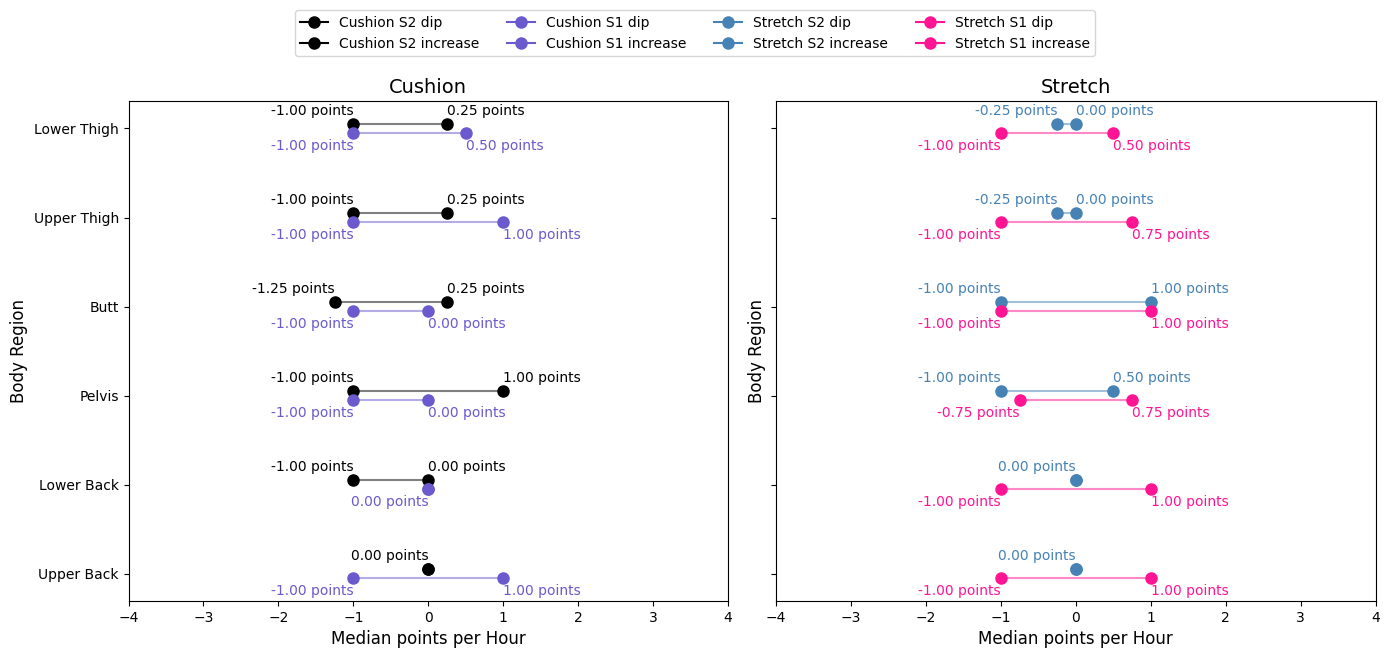

Cushion Upper Back: S2 -> Dip during break: -1.0 Increase after break: 0.0 + S1 -> Dip during break: -1.0 Increase after break: 1.0
Cushion Lower Back: S2 -> Dip during break: 0.0 Increase after break: 0.0 + S1 -> Dip during break: -1.0 Increase after break: 0.0
Cushion pelvis_rating: S2 -> Dip during break: -0.8 Increase after break: 0.5 + S1 -> Dip during break: -1.0 Increase after break: 0.0
Cushion butt_rating: S2 -> Dip during break: -1.0 Increase after break: 1.0 + S1 -> Dip during break: -1.0 Increase after break: 1.0
Cushion upper_thigh_rating: S2 -> Dip during break: -1.0 Increase after break: 1.0 + S1 -> Dip during break: -0.8 Increase after break: 0.8
Cushion lower_thigh_rating: S2 -> Dip during break: -1.0 Increase after break: 1.0 + S1 -> Dip during break: -1.0 Increase after break: 0.8


Stretch Upper Back: S2 -> Dip during break: 0.0 Increase after break: 0.0 + S1 -> Dip during break: 0.0 Increase after break: 0.0
Stretch Lower Back: S2 -> Dip during break: -0.5 Increase

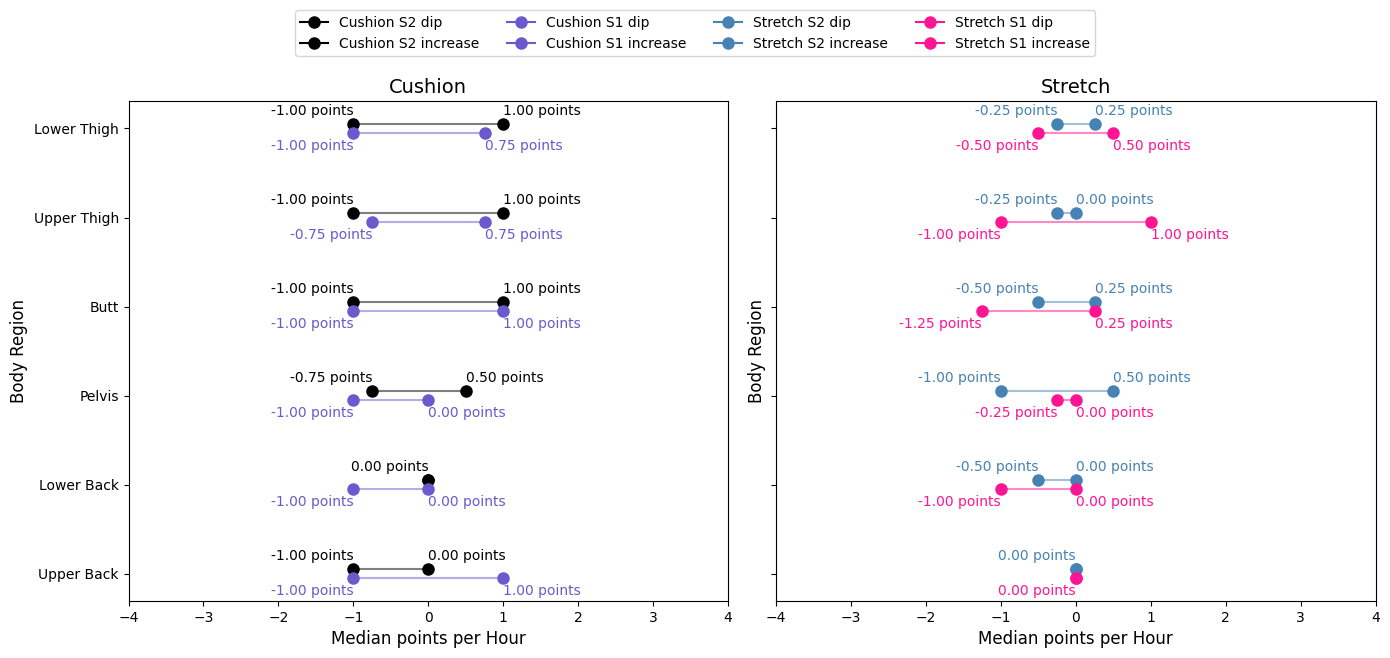

In [21]:
def dips(df, col, a, b):
    ratings = [np.median(df[df['group'] == i][col]) for i in range(a, b, 1)]
    return ratings[1] - ratings[0], ratings[2] - ratings[1]

def dips_all(a=7, b=10):
    regions = ['Upper Back', 'Lower Back', 'Pelvis', 'Butt', 'Upper Thigh', 'Lower Thigh']
    S1_dip_cs, S2_dip_cs, S1_inc_cs, S2_inc_cs = [[], []], [[], []], [[], []], [[], []]
    
    for i, met in enumerate(['cushion', 'stretch']):
        for col in all_rating_columns:
            dip_a, dip_b = dips(full_rating_data[(full_rating_data['method'] == met) & (full_rating_data['study'] == 'Study 2')], col, a, b)
            dip1_a, dip1_b = dips(full_rating_data[(full_rating_data['method'] == met) & (full_rating_data['study'] == 'Study 1')], col, a, b)

            S1_dip_cs[i].append(dip1_a)
            S2_dip_cs[i].append(dip_a)
            S1_inc_cs[i].append(dip1_b)
            S2_inc_cs[i].append(dip_b)
            
            print(f"{met.capitalize()} {col}: S2 -> Dip during break: {dip_a:.1f} Increase after break: {dip_b:.1f} + S1 -> Dip during break: {dip1_a:.1f} Increase after break: {dip1_b:.1f}")
        print("\n")

    fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)    
    for j, method in enumerate(['Cushion', 'Stretch']):
        for i in range(len(all_rating_columns)):
            # S2
            axs[j].plot([S2_dip_cs[j][i], S2_inc_cs[j][i]], [i + 0.05, i + 0.05], marker='o', color=colors[j], markersize=5, alpha=0.5)
            axs[j].plot(S2_dip_cs[j][i], i + 0.05, marker='o', color=colors[j], markersize=8, label=f'{method} S2 dip' if i == 0 else "")
            axs[j].plot(S2_inc_cs[j][i], i + 0.05, marker='o', color=colors[j], markersize=8, label=f'{method} S2 increase' if i == 0 else "")
    
            axs[j].text(S2_dip_cs[j][i], i + 0.2, f'{S2_dip_cs[j][i]:.2f} points', va='center', color=colors[j], fontsize=10, ha='right')
            if S2_dip_cs[j][i] != S2_inc_cs[j][i]:
                axs[j].text(S2_inc_cs[j][i], i + 0.2, f'{S2_inc_cs[j][i]:.2f} points', va='center', color=colors[j], fontsize=10, ha='left')
    
            # S1
            axs[j].plot([S1_dip_cs[j][i], S1_inc_cs[j][i]], [i - 0.05, i - 0.05], marker='o', color=colors1[j], markersize=5, alpha=0.5)
            axs[j].plot(S1_dip_cs[j][i], i - 0.05, marker='o', color=colors1[j], markersize=8, label=f'{method} S1 dip' if i == 0 else "")
            axs[j].plot(S1_inc_cs[j][i], i - 0.05, marker='o', color=colors1[j], markersize=8, label=f'{method} S1 increase' if i == 0 else "")
    
            axs[j].text(S1_dip_cs[j][i], i - 0.2, f'{S1_dip_cs[j][i]:.2f} points', va='center', color=colors1[j], fontsize=10, ha='right')
            if S1_dip_cs[j][i] != S1_inc_cs[j][i]:
                axs[j].text(S1_inc_cs[j][i], i - 0.2, f'{S1_inc_cs[j][i]:.2f} points', va='center', color=colors1[j], fontsize=10, ha='left')
    
            axs[j].set_xlabel('Median points per Hour', fontsize=12)
            axs[j].set_ylabel('Body Region', fontsize=12)
            axs[j].set_title(f'{method}', fontsize=14)
            axs[j].set_yticks(range(len(regions)))
            axs[j].set_yticklabels(regions, fontsize=10)
            axs[j].set_xlim(-4, 4)
    
    fig.legend(loc='upper center', fontsize=10, bbox_to_anchor=(0.5, 1.1), ncol=4)
    plt.tight_layout()
    plt.show()

dips_all()
dips_all(14, 17)

## Starting and Ending ratings

Cushion Upper Back: S2 -> Starting: 1.0 Ending: 3.0 + S1 -> Starting: 1.0 Ending: 3.5
Cushion Lower Back: S2 -> Starting: 1.0 Ending: 4.0 + S1 -> Starting: 1.0 Ending: 4.0
Cushion pelvis_rating: S2 -> Starting: 1.0 Ending: 4.0 + S1 -> Starting: 1.0 Ending: 4.0
Cushion butt_rating: S2 -> Starting: 1.0 Ending: 4.8 + S1 -> Starting: 1.0 Ending: 5.0
Cushion upper_thigh_rating: S2 -> Starting: 1.0 Ending: 3.8 + S1 -> Starting: 1.0 Ending: 4.0
Cushion lower_thigh_rating: S2 -> Starting: 1.0 Ending: 3.2 + S1 -> Starting: 1.0 Ending: 3.5
Stretch Upper Back: S2 -> Starting: 1.0 Ending: 2.5 + S1 -> Starting: 1.0 Ending: 4.0
Stretch Lower Back: S2 -> Starting: 1.0 Ending: 3.0 + S1 -> Starting: 1.0 Ending: 4.5
Stretch pelvis_rating: S2 -> Starting: 1.0 Ending: 3.0 + S1 -> Starting: 1.0 Ending: 4.0
Stretch butt_rating: S2 -> Starting: 1.0 Ending: 4.0 + S1 -> Starting: 1.0 Ending: 4.5
Stretch upper_thigh_rating: S2 -> Starting: 1.0 Ending: 3.0 + S1 -> Starting: 1.0 Ending: 4.0
Stretch lower_thigh_ra

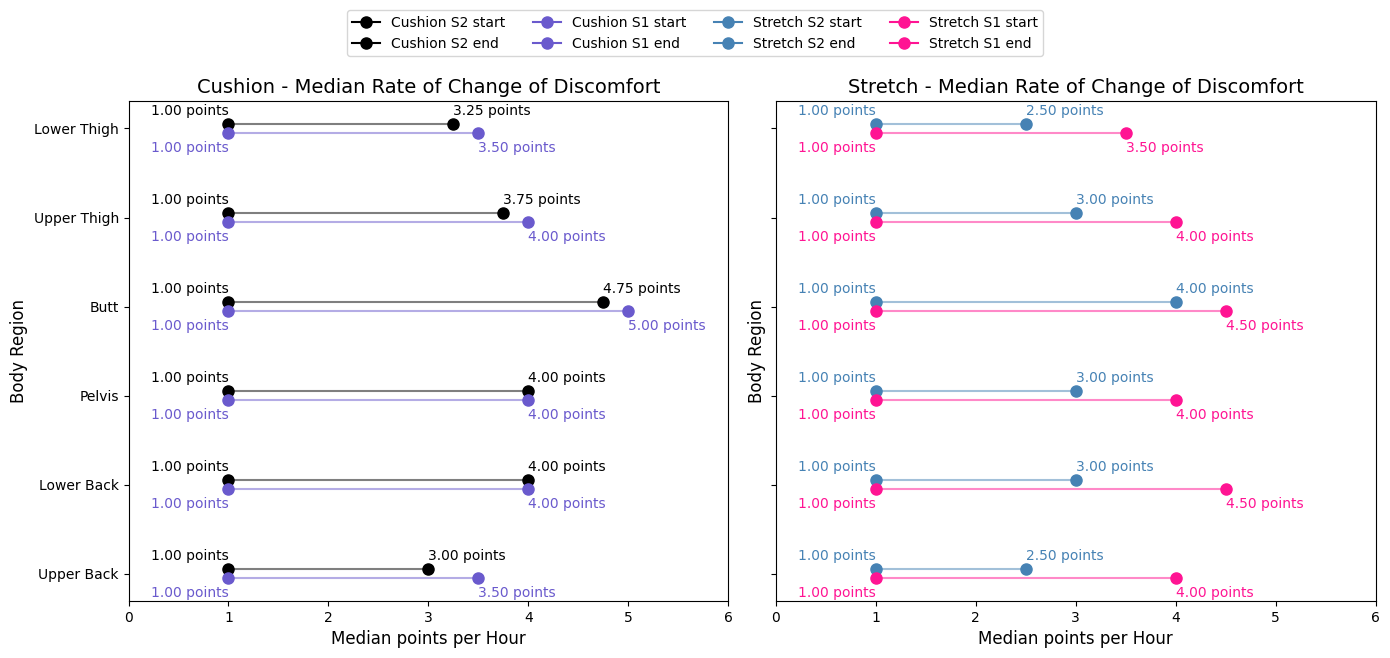

In [22]:
def start_end(df, col):
    ratings = [np.median(df[df['group'] == i][col]) for i in [1, 21]]
    return ratings[0], ratings[1]
    
def start_end_all():
    regions = ['Upper Back', 'Lower Back', 'Pelvis', 'Butt', 'Upper Thigh', 'Lower Thigh']
    S2_start_cs, S2_end_cs, S1_start_cs, S1_end_cs = [], [], [], []
    
    for met in ['cushion', 'stretch']:
        S2_start_curr, S2_end_curr, S1_start_curr, S1_end_curr = [], [], [], []
        for col in all_rating_columns:
            st, e = start_end(full_rating_data[(full_rating_data['method'] == met) & (full_rating_data['study'] == 'Study 2')], col)
            st1, e1 = start_end(full_rating_data[(full_rating_data['method'] == met) & (full_rating_data['study'] == 'Study 1')], col)

            print(f"{met.capitalize()} {col}: S2 -> Starting: {st:.1f} Ending: {e:.1f} + S1 -> Starting: {st1:.1f} Ending: {e1:.1f}")

            if col == 'total_rating':
                continue

            S2_start_curr.append(st)
            S2_end_curr.append(e)
            S1_start_curr.append(st1)
            S1_end_curr.append(e1)
            
        S2_start_cs.append(S2_start_curr)
        S2_end_cs.append(S2_end_curr)
        S1_start_cs.append(S1_start_curr)
        S1_end_cs.append(S1_end_curr)
            
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    
    for j, method in enumerate(['Cushion', 'Stretch']):
        for i in range(len(regions)):
            # S2
            axs[j].plot([S2_start_cs[j][i], S2_end_cs[j][i]], [i + 0.05, i + 0.05], marker='o', color=colors[j], markersize=5, alpha=0.5)
            axs[j].plot(S2_start_cs[j][i], i + 0.05, marker='o', color=colors[j], markersize=8, label=f'{method} S2 start' if i == 0 else "")
            axs[j].plot(S2_end_cs[j][i], i + 0.05, marker='o', color=colors[j], markersize=8, label=f'{method} S2 end' if i == 0 else "")
    
            axs[j].text(S2_start_cs[j][i], i + 0.2, f'{S2_start_cs[j][i]:.2f} points', va='center', color=colors[j], fontsize=10, ha='right')
            if S2_start_cs[j][i] != S2_end_cs[j][i]:
                axs[j].text(S2_end_cs[j][i], i + 0.2, f'{S2_end_cs[j][i]:.2f} points', va='center', color=colors[j], fontsize=10, ha='left')
    
            # S1
            axs[j].plot([S1_start_cs[j][i], S1_end_cs[j][i]], [i - 0.05, i - 0.05], marker='o', color=colors1[j], markersize=5, alpha=0.5)
            axs[j].plot(S1_start_cs[j][i], i - 0.05, marker='o', color=colors1[j], markersize=8, label=f'{method} S1 start' if i == 0 else "")
            axs[j].plot(S1_end_cs[j][i], i - 0.05, marker='o', color=colors1[j], markersize=8, label=f'{method} S1 end' if i == 0 else "")
    
            axs[j].text(S1_start_cs[j][i], i - 0.22, f'{S1_start_cs[j][i]:.2f} points', va='center', color=colors1[j], fontsize=10, ha='right')
            if S1_start_cs[j][i] != S1_end_cs[j][i]:
                axs[j].text(S1_end_cs[j][i], i - 0.22, f'{S1_end_cs[j][i]:.2f} points', va='center', color=colors1[j], fontsize=10, ha='left')
    
            axs[j].set_xlabel('Median points per Hour', fontsize=12)
            axs[j].set_ylabel('Body Region', fontsize=12)
            axs[j].set_title(f'{method} - Median Rate of Change of Discomfort', fontsize=14)
            axs[j].set_yticks(range(len(regions)))
            axs[j].set_yticklabels(regions, fontsize=10)
            axs[j].set_xlim(0, 6)
    
    fig.legend(loc='upper center', fontsize=10, bbox_to_anchor=(0.5, 1.1), ncol=4)
    plt.tight_layout()
    plt.show()

start_end_all()

## Average increase in ratings

378
Upper Back cushion 2.3
420
Upper Back stretch 1.9


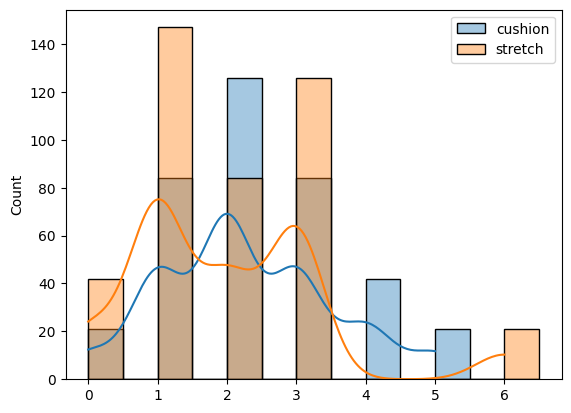

Mean: cushion: 2.278 stretch: 1.950
Median: cushion: 2.000 stretch: 2.000
Hypothesis test
Non-normal distribution... Using Kruskal and Dunn posthoc tests...
2.667802979258743e-05
The following are statistically different:
cushion and stretch 0.000
Effect size 0.251
378
Lower Back cushion 2.7
420
Lower Back stretch 2.3


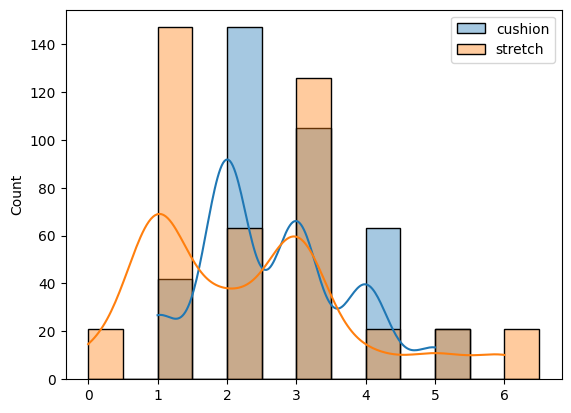

Mean: cushion: 2.667 stretch: 2.300
Median: cushion: 2.500 stretch: 2.000
Hypothesis test
Non-normal distribution... Using Kruskal and Dunn posthoc tests...
3.422291552966714e-07
The following are statistically different:
cushion and stretch 0.000
Effect size 0.281
378
pelvis_rating cushion 3.1
420
pelvis_rating stretch 2.6


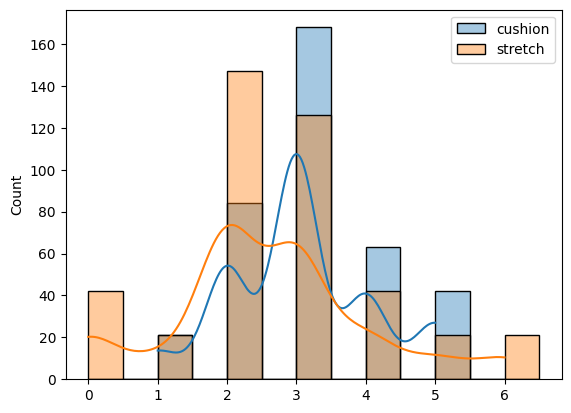

Mean: cushion: 3.056 stretch: 2.600
Median: cushion: 3.000 stretch: 2.500
Hypothesis test
Non-normal distribution... Using Kruskal and Dunn posthoc tests...
1.0715385289165179e-08
The following are statistically different:
cushion and stretch 0.000
Effect size 0.363
378
butt_rating cushion 3.0
420
butt_rating stretch 2.8


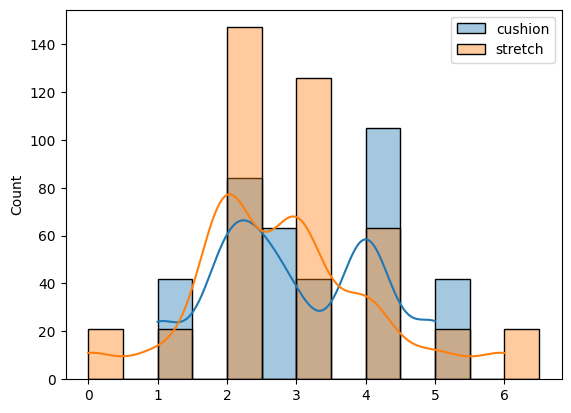

Mean: cushion: 2.972 stretch: 2.800
Median: cushion: 2.750 stretch: 3.000
Hypothesis test
Non-normal distribution... Using Kruskal and Dunn posthoc tests...
0.03149765705815467
The following are statistically different:
cushion and stretch 0.031
Effect size 0.136
378
upper_thigh_rating cushion 2.4
420
upper_thigh_rating stretch 2.1


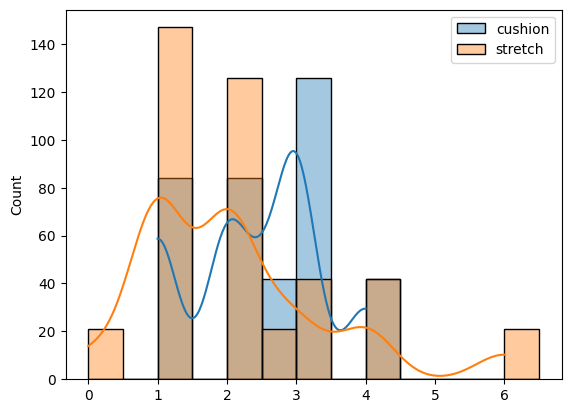

Mean: cushion: 2.389 stretch: 2.075
Median: cushion: 2.500 stretch: 2.000
Hypothesis test
Non-normal distribution... Using Kruskal and Dunn posthoc tests...
2.0339297557030143e-09
The following are statistically different:
cushion and stretch 0.000
Effect size 0.265
378
lower_thigh_rating cushion 2.1
420
lower_thigh_rating stretch 1.8


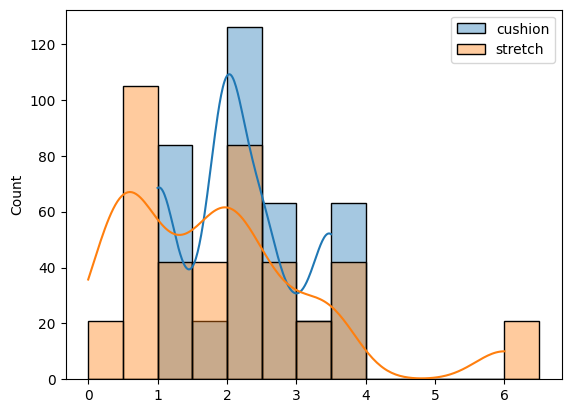

Mean: cushion: 2.139 stretch: 1.825
Median: cushion: 2.000 stretch: 1.750
Hypothesis test
Non-normal distribution... Using Kruskal and Dunn posthoc tests...
8.925726348341487e-10
The following are statistically different:
cushion and stretch 0.000
Effect size 0.269


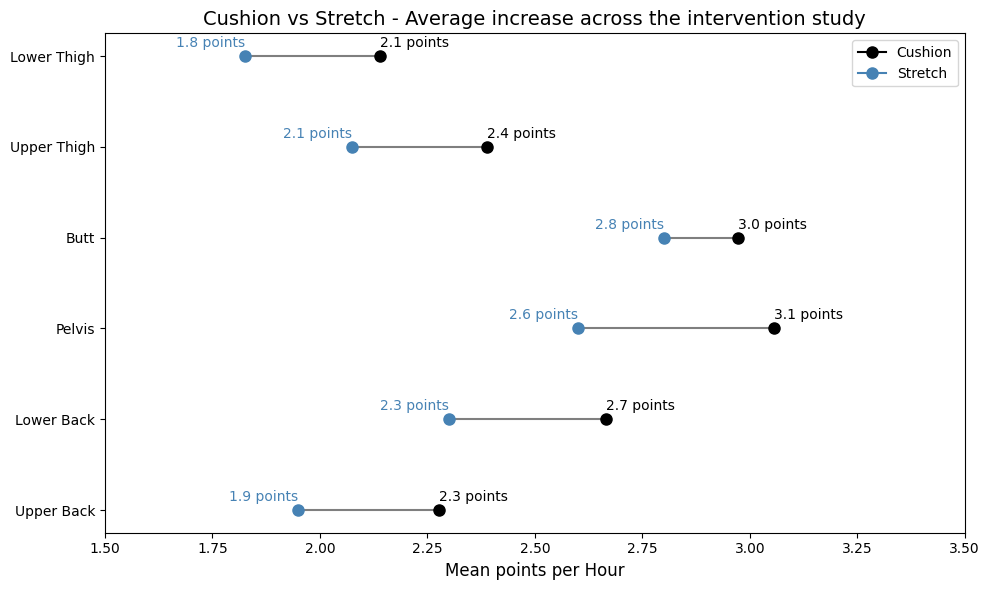

In [23]:
def start_end_diff(df, col, subject):
    start = df[(df['subject'] == subject) & (df['group'] == 1)][col].item() 
    end = df[(df['subject'] == subject) & (df['group'] == 21)][col].item()
    return end - start
    
def start_end_diff_all():
    mean_points = [[],[],[],[],[],[]]
    
    for i, col in enumerate(all_rating_columns):
        all_diffs = []
        for j, met in enumerate(['cushion', 'stretch']):
            subs = full_rating_data[(full_rating_data['method'] == met) & (full_rating_data['study'] == 'Study 2') & (full_rating_data['significant'] == 'yes')]
            print(len(subs))
            diffs = subs.drop_duplicates().apply(lambda x: start_end_diff(subs, col, x['subject']), axis=1)
            all_diffs.append(diffs)
            
            print(f"{col} {met} {np.mean(diffs):.1f}")
            mean_points[i].append(np.mean(diffs))

    # for j, met in enumerate(['cushion', 'stretch']):
    #     subs = full_rating_data[(full_rating_data['method'] == met) & (full_rating_data['study'] == 'Study 2') & (full_rating_data['significant'] == 'yes')]
    #     print(len(subs))
    #     diffs = subs.drop_duplicates().apply(lambda x: start_end_diff(subs, 'total_rating', x['subject']), axis=1)
    #     print(f"tr {met} {np.mean(diffs):.1f}")
            
        mp.two_sample_plot(all_diffs[0], "cushion",  all_diffs[1], "stretch", 0.5)

    regions = ['Upper Back', 'Lower Back', 'Pelvis', 'Butt', 'Upper Thigh', 'Lower Thigh']
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    for i, region in enumerate(regions):
        ax.plot([mean_points[i][0], mean_points[i][1]], [i, i], color='black', alpha=0.5, marker='o', markersize=5)
        ax.plot(mean_points[i][0], i, marker='o', color=colors[0], markersize=8, label='Cushion' if i == 0 else "")
        ax.plot(mean_points[i][1], i, marker='o', color=colors[1], markersize=8, label='Stretch' if i == 0 else "")
    
        if mean_points[i][0] > mean_points[i][1]:
            ax.text(mean_points[i][0], i + 0.1, f'{mean_points[i][0]:.1f} points', color=colors[0], fontsize=10, ha='left')
            ax.text(mean_points[i][1], i + 0.1, f'{mean_points[i][1]:.1f} points', color=colors[1], fontsize=10, ha='right')
        else:
            ax.text(mean_points[i][0], i + 0.1, f'{mean_points[i][0]:.1f} points', color=colors[0], fontsize=10, ha='right')
            ax.text(mean_points[i][1], i + 0.1, f'{mean_points[i][1]:.1f} points', color=colors[1], fontsize=10, ha='left')
            
    ax.set_yticks(range(len(regions)))
    ax.set_yticklabels(regions, fontsize=10)
    ax.set_xlabel('Mean points per Hour', fontsize=12)
    ax.set_title('Cushion vs Stretch - Average increase across the intervention study', fontsize=14)
    ax.set_xlim(1.5, 3.5)
    
    # Legend
    ax.legend(loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.show()

start_end_diff_all()

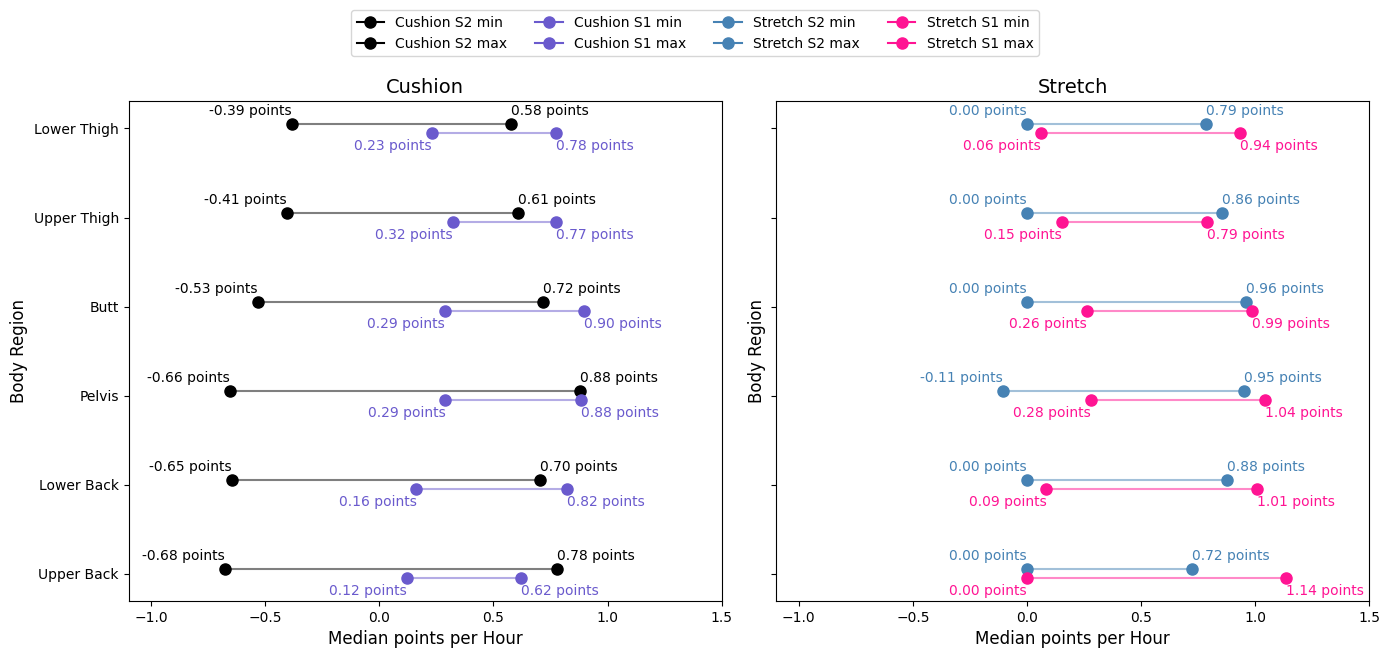

In [24]:
def slope(df, col, subject):
    times = [i for i in range(0, 121, 20)]
    times.extend([i for i in range(145, 248, 20)])
    times.extend([i for i in range(270, 375, 20)])
    times = [x / 60 for x in times]

    ratings = df[df['subject'] == subject]
    ratings = ratings[~ratings['group'].isin([8, 15])][col]
    return linregress(times, ratings).slope, linregress(times, ratings).rvalue ** 2

def slope_all():
    regions = ['Upper Back', 'Lower Back', 'Pelvis', 'Butt', 'Upper Thigh', 'Lower Thigh']
    S1_min_cs, S2_min_cs, S1_max_cs, S2_max_cs = [[], []], [[], []], [[], []], [[], []]

    for i, met in enumerate(['cushion', 'stretch']):
        for col in all_rating_columns:
            curr = full_rating_data[(full_rating_data['method'] == met) & (full_rating_data['study'] == 'Study 2')]
            curr = curr[~curr['subject'].isin(['B052', 'B109', 'B194', 'B198', 'B118'])]
            curr['slope'] = curr['subject'].apply(lambda x: slope(curr, col, x)[0])

            curr1 = full_rating_data[(full_rating_data['method'] == met) & (full_rating_data['study'] == 'Study 1')]
            curr1 = curr1[~curr1['subject'].isin(['A052', 'A109', 'A194', 'A198', 'A118'])]
            curr1['slope'] = curr1['subject'].apply(lambda x: slope(curr1, col, x)[0])

            S1_min_cs[i].append(np.min(curr1['slope']))
            S2_min_cs[i].append(np.min(curr['slope']))
            S1_max_cs[i].append(np.max(curr1['slope']))
            S2_max_cs[i].append(np.max(curr['slope']))

    fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)    
    for j, method in enumerate(['Cushion', 'Stretch']):
        for i in range(len(all_rating_columns)):
            # S2
            axs[j].plot([S2_min_cs[j][i], S2_max_cs[j][i]], [i + 0.05, i + 0.05], marker='o', color=colors[j], markersize=5, alpha=0.5)
            axs[j].plot(S2_min_cs[j][i], i + 0.05, marker='o', color=colors[j], markersize=8, label=f'{method} S2 min' if i == 0 else "")
            axs[j].plot(S2_max_cs[j][i], i + 0.05, marker='o', color=colors[j], markersize=8, label=f'{method} S2 max' if i == 0 else "")
    
            axs[j].text(S2_min_cs[j][i], i + 0.2, f'{S2_min_cs[j][i]:.2f} points', va='center', color=colors[j], fontsize=10, ha='right')
            if S2_min_cs[j][i] != S2_max_cs[j][i]:
                axs[j].text(S2_max_cs[j][i], i + 0.2, f'{S2_max_cs[j][i]:.2f} points', va='center', color=colors[j], fontsize=10, ha='left')
    
            # S1
            axs[j].plot([S1_min_cs[j][i], S1_max_cs[j][i]], [i - 0.05, i - 0.05], marker='o', color=colors1[j], markersize=5, alpha=0.5)
            axs[j].plot(S1_min_cs[j][i], i - 0.05, marker='o', color=colors1[j], markersize=8, label=f'{method} S1 min' if i == 0 else "")
            axs[j].plot(S1_max_cs[j][i], i - 0.05, marker='o', color=colors1[j], markersize=8, label=f'{method} S1 max' if i == 0 else "")
    
            axs[j].text(S1_min_cs[j][i], i - 0.2, f'{S1_min_cs[j][i]:.2f} points', va='center', color=colors1[j], fontsize=10, ha='right')
            if S1_min_cs[j][i] != S1_max_cs[j][i]:
                axs[j].text(S1_max_cs[j][i], i - 0.2, f'{S1_max_cs[j][i]:.2f} points', va='center', color=colors1[j], fontsize=10, ha='left')
    
            axs[j].set_xlabel('Median points per Hour', fontsize=12)
            axs[j].set_ylabel('Body Region', fontsize=12)
            axs[j].set_title(f'{method}', fontsize=14)
            axs[j].set_yticks(range(len(regions)))
            axs[j].set_yticklabels(regions, fontsize=10)
            axs[j].set_xlim(-1.1, 1.5)
    
    fig.legend(loc='upper center', fontsize=10, bbox_to_anchor=(0.5, 1.1), ncol=4)
    plt.tight_layout()
    plt.show()

slope_all()

## Initial / Final Rating distribution

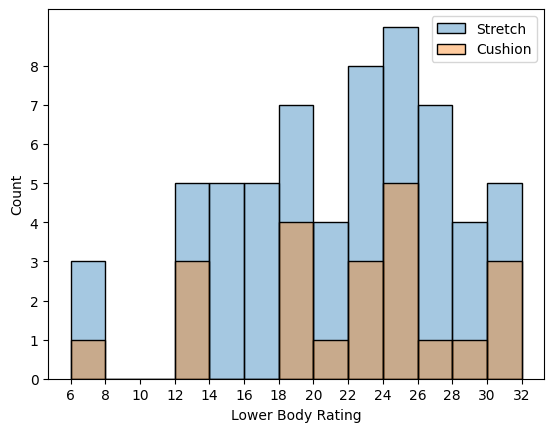

In [25]:
data = full_rating_data[full_rating_data['group'] == 21]
rating_col = ['total_rating', 'upper_rating', 'lower_rating'][2]

data['method'] = data['subject'].apply(lambda x: 'cushion' if x in cushion_subjects_s2 else 'stretch')
data['method'] = data['method'].astype('category')

data1 = data[data['method'] == 'stretch'][rating_col]
data2 = data[data['method'] == 'cushion'][rating_col]
bin_width = 4

# bins = np.arange(math.floor(min(min(data1), min(data2))), math.ceil(max(max(data1), max(data2)) + bin_width), bin_width)
bins = np.arange(6, 34, 2)
sns.histplot(data1, kde=False, bins=bins, alpha=0.4, label='Stretch')
sns.histplot(data2, kde=False, bins=bins, alpha=0.4, label='Cushion')


plt.xlabel('Lower Body Rating')
plt.ylabel('Count')
plt.xticks(np.arange(6, 34, step=2))
plt.yticks(np.arange(0, 9, step=1))
#plt.title(title)
    
plt.legend()
plt.show()